In [860]:
import os
from os.path import join
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn import svm
from sklearn.mixture import GaussianMixture
import pandas as pd
from scipy.signal import savgol_filter, deconvolve, find_peaks, peak_widths
from scipy.stats import zscore, norm
from scipy.fft import fft, fftfreq
import seaborn as sns
import mne
from mne.stats.regression import linear_regression_raw, linear_regression
from mne.stats import bootstrap_confidence_interval
import ast
import math
import csv

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
import os
os.environ['OPENBLAS_NUM_THREADS'] = '8'
os.environ['MKL_NUM_THREADS'] = '8'
os.environ["NUMEXPR_NUM_THREADS"] = '8' 
os.environ["OMP_NUM_THREADS"] = '8' 

## Define functions

In [1045]:
# function to find index of nearest value
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

# from Jorie
def sync_timing(df, sync_val, timingname='timing', new_timingname='timing_meg',
                              timingname_offset='timing_offset', new_timingname_offset='timing_offset_meg'):
    """use syncing value to get timings from stimpc domain into the MEG clock domain
    input df and sync value, returns adjusted dataframe"""

    # create new column in old dataframe
    df[new_timingname] = df[timingname] + sync_val
    df[new_timingname_offset] = df[timingname_offset] + sync_val
    # and return
    return(df)

## MOVE FUNCTIONS FROM STIMULUS DOMAIN INTO TIMEDOMAIN
## MAP 'STIMULUS' TO INDEX OF WHAT STIMULI, FOR EASY MAPPING

def stim_save_segments(df_beh, groupby_nm=['block', 'segment']):
    """apply a new column to behavioural dataframe with segment_all - 
    indicating a continious numerical indicator of what segment we are on"""

    # predefine segement all in df_beh
    df_beh['segment_all'] = np.nan
    
    # loop over block and segment combinations
    for idx, row in df_beh.groupby(groupby_nm).first().reset_index().iterrows():

        # save new segment all 
        df_beh.loc[(df_beh['block'] == row['block']) & (df_beh['segment'] == row['segment']), 'segment_all'] = idx 

    # return the dataframe
    return(df_beh)


def map_stim_to_time(df, df_beh, cn_stim='stimulus', cn_ts='TIMESTAMP', 
                     beh_cn_onset='timing_meg', beh_cn_offset='timing_offset_meg'):
    """transform / map stimulus dataframe into the time domain
    input: df: Pandas dataframe - time domain
           df_beh: Pandas dataframe - stim domain
           cn_stim: (optional) column name for stimulus indicator
           cn_ts: (optional) column name for timestamp indicater in time df
           beh_cn_onset: (optional) column name for onset time in beh_df
           beh_cn_offset: (optional) column name for offset time in beh_df"""
    
    # Apply the function to create the 'stimulus' column in df_time
    df['stimulus'] = df[cn_ts].apply(_assign_stimulus, 
                                           df_beh=df_beh,
                                           cn_onset=beh_cn_onset,
                                           cn_offset=beh_cn_offset,
                                           cn_stimulus=cn_stim)
    # Return the dataframe
    return(df)


def map_columns_to_time(df, df_beh, col_to_trans, indicator_nm='stimulus'):
    """map columns of interest to transfer to timedomain
    df: dataframe in timedomain
    df_beh: dataframe in stim domain
    col_to_trans: all columns to transfer
    indicator_nm: (optional) indicator name - what to use for the mapping"""
    
    # loop over columns to transfer
    for colnm in col_to_trans:

        # create a dictionary to map 'stimulus' to all conditions I want to transfer to the other df
        stimulus_to_col = df_beh.set_index(indicator_nm)[colnm].to_dict()

        # map function to go from one to another
        df[colnm] = df[indicator_nm].map(stimulus_to_col).fillna(0)
        
    # returns dataframe
    return(df)


def map_block_to_run(df, df_beh, run_nm='run', block_nm_beh='block', block_nm='BLOCK'):
    """map from blocknumber to run number in timedomain"""

    # create a dictionary to map 'block' to run
    map_block_run = df_beh.set_index(block_nm_beh)[run_nm].to_dict()

    # map the df
    df[run_nm] = df[block_nm].map(map_block_run).fillna(0).astype(int)

    # return dataframe
    return(df)


def time_save_segments(df, df_beh,
                       groupby_nm=['block', 'segment'],
                       onset_nm='timing_meg',
                       offset_nm='timing_offset_meg',
                       timing_mm='TIMESTAMP'
                      ):
    """save segments into the time domain dataframe
    df: timedomain dataframe
    df_beh: stimdomain dataframe
    groupby_nm: (optional) list of names to groupby
    onset_nm: (optional) what to use as onset timings - in same timeframe
    offset_nm: (optional) what to use as offset timings - in same timeframe
    timing_nm: (optional) time indicator in original dataframe"""

    # get dataframe of onset and offset timings only
    onset_df = df_beh.groupby(groupby_nm).first()[onset_nm].reset_index()
    offset_df = df_beh.groupby(groupby_nm).last()[offset_nm].reset_index()

    # predefine all new columns in our timedomain dataframe
    # df['block'] = np.nan
    df['segment'] = np.nan
    df['segment_all'] = np.nan

    # loop over all index (combinations)
    for idx, row in onset_df.iterrows():

        # get start and endtime of groupby section
        cur_onset = onset_df[onset_nm].iloc[idx]
        cur_offset = offset_df[offset_nm].iloc[idx]

        # map to OG dataframe
        df.loc[(df[timing_mm] >= cur_onset) & (df[timing_mm] <= cur_offset), 'segment'] = onset_df['segment'].iloc[idx]

        # save per segment indicator
        df.loc[(df[timing_mm] >= cur_onset) & (df[timing_mm] <= cur_offset), 'segment_all'] = idx
    
    return(df)


def time_save_onoff(df, onoff_nm='onoff', indicator='stimulus'):
    """save onoff value (bool), based on indicator value"""

    # predefine
    df[onoff_nm] = 0
    # take wherever there is any stimulus - set to 1
    df.loc[(df[indicator] > 0), onoff_nm] = 1
    
    return(df)


# create a function to assign stimuli based on timing
def _assign_stimulus(timing, 
                     df_beh, 
                     cn_onset='timing_meg', 
                     cn_offset='timing_offset_meg',
                     cn_stimulus='stimulus'):
    """pandas apply function to get stimuli into the time domain
    input df_beh, cn_onset (optional columnname of onset time),
    cn_offset (optional columnname of offset time), cn_stimulus (optional columnname of stimulus)"""
    idx = np.searchsorted(df_beh[cn_onset], timing)
    if idx == 0 or timing >= df_beh[cn_offset].iloc[idx - 1]:
        return 0
    return df_beh[cn_stimulus].iloc[idx - 1]

def time_transform_FIR(df, indicator, fir_columns,
                       prefix_fir = 'FIR_',
                       prefix_fir_offset = 'OFFSET_FIR_'):
    """within a dataframe, groupby indicator > loop over fir columns and make a boxplot a impulse (start + end)
    input: df: timedomain dataframe
           indicator: indicator for groupby (unqiue indicator that binds the fir_columns)
           fir_columns: the fir columns to loop over and add
           prefix_fir: (optional) prefix naming for new fir naming
           prefix_fir_offset: (optional) prefix naming for new fir ofset naming
    return: return adjusted dataframe
    """

    # create onset and ofset arrays for FIR modelling - per stimulus
    onset_idx  = df[df[indicator] > 0].groupby(indicator).apply(lambda x: x.index[0]).to_numpy()  # onset
    offset_idx = df[df[indicator] > 0].groupby(indicator).apply(lambda x: x.index[-1]).to_numpy() # offset

    # loop over columns of interest to re-insert into df as FIR
    for col in fir_columns:

        # predefine columns
        df[f'{prefix_fir}{col}'] = 0
        df[f'{prefix_fir_offset}{col}'] = 0

        # take first or last value from boxplot and make FIR
        df.loc[onset_idx, f'{prefix_fir}{col}'] = df.loc[onset_idx, col]
        df.loc[offset_idx, f'{prefix_fir_offset}{col}'] = df.loc[offset_idx, col]
        
    return(df)

def add_event_from_df(raw, df, event_nm):
    """within the raw MNE object, using the matching nonzero indexes in df to add mne events
    input: raw: mne raw object - must include 'sfreq', here we add stim to
            df: dataframe with our stimulus (impulse/block) information
            event_nm: the name of the column in the dataframe which is the event
    output: returns raw mne object with object"""

    # calulate index position of events and the value of those events
    idxs      = np.where(df[event_nm] > 0)
    value     = df[event_nm].to_numpy()[idxs]

    # predefine numpy array in correct shape for mne
    mne_arr = np.zeros((len(idxs[0]), 3))
    mne_arr[:,0] = idxs[0]
    mne_arr[:,2] = value



    # add actuall events
    raw.add_events(mne_arr, stim_channel=event_nm, replace=True)
    return(raw)


# # combine pupil data and behavioural data and perform linear regression
def pupil_data_lin_reg(df_beh, pupil_df, column_of_interest='onoff', 
                       sampling_rate='auto',
                       t_start = -1, t_end = 20,
                       baseline = (-1,1), 
                       z_scored = False,
                       *args):
    """ combine behavioural df and pupil df and apply a linear regression on the resulting df 
        df_beh:   dataframe containing behavioural data
        pupil_df: dataframe containing pupil data
        column_of_interest: column of interest in behavioural df
        t_start: timepoint of start
        t_end: timepoint of end
        baseline: touple of baseline period
        z_scored: boolean, deciding whether z-scoring column_of_interest

        returns: beta_values, p_values
    """
    # automatically fetch sampling-rate
    if sampling_rate == 'auto': 
        sampling_rate = round(1/np.mean(np.diff(pupil_df.time[0:9])))
    
    # get MNE objects    
    [events, epochs, raw, event_columns] = pupil_data_to_MNE(df_beh, pupil_df, 
                                                             column_of_interest=column_of_interest, 
                                                             sampling_rate=sampling_rate,
                                                             t_start=t_start, t_end=t_end, 
                                                             baseline=baseline)
    
    # Get the data for the 'FIR_drex_surp' channel
    fir_surprisal_data = raw.copy().pick_channels([event_columns[0]]).get_data()
    
    # get list of bad epochs
    bad_e = []
    for idx,b in enumerate(epochs.drop_log):
        if b == ('NO_DATA',):
            bad_e.append(idx)
            # print(idx)
        elif b == ('TOO_SHORT',):
            # print(idx)
            bad_e.append(idx)
    # remove bad epochs from data
    fit_surp_no_bad = fir_surprisal_data[fir_surprisal_data > 0]
    fit_surp_no_bad = np.delete(fit_surp_no_bad, bad_e)

    if z_scored:
        epochs.apply_function(lambda x: zscore(x), picks=['pupil', event_columns[0]])
    
    # Perform linear regression - in this case for drex_surp
    # if column_of_interest == 'onoff':
    res = linear_regression(epochs, fit_surp_no_bad[fit_surp_no_bad>0, np.newaxis], names=[event_columns[0]])
    fig, ax = plt.subplots()
    ax.plot(fit_surp_no_bad[fit_surp_no_bad>0, np.newaxis]);
    # else:
    #     ones = np.full((len(fit_surp_no_bad>0)), 1)
    #     res = linear_regression(epochs, np.array([fit_surp_no_bad[fit_surp_no_bad>0],ones]).T, names=[event_columns[0],'FIR_onoff'])
    #     fig, ax = plt.subplots()
    #     ax.plot(np.array([fit_surp_no_bad[fit_surp_no_bad>0],ones]).T);
    
    # Access the beta values and related information
    beta_values = res[event_columns[0]].beta
    t_values = res[event_columns[0]].t_val
    p_values = res[event_columns[0]].p_val
    return beta_values, p_values



def pupil_data_to_MNE(df_beh, pupil_df, column_of_interest='onoff', 
                      sampling_rate='auto', 
                      t_start = -1, t_end = 20,
                      baseline = (-1,1),
                      *args):
    """ combine behavioural df and pupil df and turn into MNE objects
        df_beh:   dataframe containing behavioural data
        pupil_df: dataframe containing pupil data
        column_of_interest: column of interest in behavioural df
        t_start: timepoint of start
        t_end: timepoint of end
        baseline: touple of baseline period
        z_scored: boolean, deciding whether z-scoring column_of_interest

        returns: events, epochs, raw, event_columns
    """
    ##
    # Combine pupil data and behavioural data
    ##

    # automatically fetch sampling-rate
    if sampling_rate == 'auto': 
        sampling_rate = round(1/np.mean(np.diff(pupil_df.time[0:9])))
    
    df_beh = stim_save_segments(df_beh, groupby_nm=['block', 'segment']) 
    df = map_stim_to_time(pupil_df, df_beh, cn_stim='stimulus', cn_ts='time', 
                         beh_cn_onset='timing_meg', beh_cn_offset='timing_offset_meg')

    # df['stimulus'] = df[cn_ts].apply(_assign_stimulus, 
    #                                    df_beh=df_beh,
    #                                    cn_onset=beh_cn_onset,
    #                                    cn_offset=beh_cn_offset,
    #                                    cn_stimulus=cn_stim)
    
    if column_of_interest == 'onoff':
        col2trans = ['block']
    else:
        col2trans=['block',column_of_interest]

    for i in args:
        col2trans = col2trans+[i]

    df = map_columns_to_time(df, df_beh, col_to_trans=col2trans, indicator_nm='stimulus')
    df = map_block_to_run(df, df_beh, run_nm='run', block_nm_beh='block', block_nm='block')
    df = time_save_segments(df, df_beh,
                            groupby_nm=['block', 'segment'],
                            onset_nm='timing_meg',
                            offset_nm='timing_offset_meg',
                            timing_mm='time')
    df = time_save_onoff(df, onoff_nm='onoff', indicator='stimulus')
    
    # map segment specific data onto current segment
    col_to_trans = ['center_freq_a', 'center_freq_b', 'center_freq_a_oct', 'center_freq_b_oct', 'probability_a', 'probability_b']
    df = map_columns_to_time(df, df_beh, col_to_trans, indicator_nm='segment_all')

    if column_of_interest == 'onoff':
        fir_columns  =  [column_of_interest]
        event_columns = ['FIR_'+column_of_interest]
    else:
        fir_columns  =  ['onoff',column_of_interest]
        event_columns = ['FIR_'+column_of_interest, 'FIR_onoff']
    # add fir impulses to dataframe
    df = time_transform_FIR(df, 'stimulus', fir_columns)
    data = np.atleast_2d(df['pupil'].T.to_numpy())
    
    ch_names = ['pupil']
    ch_types = ['pupil']
    event_info = mne.create_info(ch_names= ch_names, ch_types= ch_types, sfreq= sampling_rate)
    raw = mne.io.RawArray(data, event_info)
    
    
    # add events for all 
    for evnt in event_columns:
        raw = add_event_from_df(raw, df, evnt)


    # Find events
    events = mne.find_events(raw, stim_channel=event_columns[0]) # do we want FIR_onoff here or our column of interest?
    print('TEST!: ', event_columns[0])
    
    # Create epochs ('timelocked data' per 'event')
    epochs = mne.Epochs(raw, events, tmin=t_start, tmax=t_end, preload=True, baseline=baseline) # performs subtractive baseline correction
    return events, epochs, raw, event_columns

import numpy as np
from sklearn.mixture import GaussianMixture

def ideal_observer(df_beh, column_oi='frequencies_oct', n_components=2, context_window=0, density_func='cdf'):
    """run ideal observer model for octave frequency data
    input: df_beh = pandas dataframe, with column_oi continues values
           column_oi = column in dataframe to fetch data from
           n_components = number of gaussians to fit
           context_window = length of contextwindow to fit, 0 means infinite
           density_func = 'cdf' or 'pdf', used as density function for calculating likelihoods
    output: returns dataframe of same length with estimated mu's, sigmas, weights, likelihoods and surprisal values"""
    
    # Initialize the Gaussian Mixture model
    gmm = GaussianMixture(n_components=n_components)

    # initate df
    df = pd.DataFrame()
    
    for block in df_beh['block'].unique():
        block_oct_dat = df_beh.loc[df_beh['block'] == block, column_oi].to_numpy()
        
        # predefine arrays
        est_meanz   = np.zeros((2, len(block_oct_dat)))
        est_varz    = np.zeros((2, len(block_oct_dat)))
        est_sigmaz  = np.zeros((2, len(block_oct_dat)))
        est_weightz = np.zeros((2, len(block_oct_dat)))
        est_meanz[:] = np.nan
        est_varz[:] = np.nan
        est_sigmaz[:] = np.nan
        est_weightz[:] = np.nan
        
        # set where to start itterating
        if context_window < n_components:
            startpoint = n_components
        else:
            startpoint = context_window
            
        # loop over all the tones
        for tone in np.arange(startpoint, len(block_oct_dat)):
            
            # cummalative data
            if context_window == 0:
                cum_data = block_oct_dat[:tone]
            else:
                cum_data = block_oct_dat[tone-context_window:tone]
          
            # Fit the model to the data
            gmm.fit(cum_data.reshape(-1, 1))  # Reshape data to match GMM input format
        
            # Get the estimated parameters
            estimated_means = gmm.means_.flatten()
            estimated_variances = gmm.covariances_.flatten()
            estimated_sigmas = np.sqrt(estimated_variances)
            estimated_weights = gmm.weights_.flatten()
            
            # sort my mean and get indexes - to always match this sorting
            idx = np.argsort(estimated_means)
            
            # save
            est_meanz[:, tone] = estimated_means[idx]
            est_varz[:, tone] = estimated_variances[idx]
            est_sigmaz[:, tone] = estimated_sigmas[idx]
            est_weightz[:, tone] = estimated_weights[idx]

        # estimate likelihood per gaussian, and combined likelihood
        if density_func == 'cdf':
            likelihoods, likelihood, surprise = _est_cdf(block_oct_dat, est_meanz, est_sigmaz, est_weightz)
        elif density_func == 'pdf':
            likelihoods, likelihood, surprise = _est_pdf(block_oct_dat, est_meanz, est_sigmaz, est_weightz)

        # gen temp dataframe
        tempdf = pd.DataFrame(np.concatenate((est_meanz, 
                                     est_varz,
                                     est_sigmaz,
                                     est_weightz,
                                     likelihoods,
                                     likelihood[np.newaxis, :],
                                     surprise[np.newaxis, :])).T,
                     columns=['mu_A', 'mu_B', 'var_A', 'var_B', 'sig_A', 'sig_B', 
                              'wg_A', 'wg_B', 'prob_A', 'prob_B', 'prob', 'surp'])
        tempdf['block'] = block

        # append dataframe
        df = pd.concat([df, tempdf], ignore_index=True)
    return df

def _est_pdf(x_data, mus, sigmas, weights):
    """estimate probability density function given 'new' datapoints (of lenght) 
    by using per timepoint mu, sigmas and weights (of shape: n-gaussians X datapoints)
    returns likelihoods, summed likelihood and surprisal value"""
    # do calculation
    likelihoods = est_weightz * norm.pdf(block_oct_dat, loc=est_meanz, scale=est_sigmaz)
    likelihood  = np.sum(likelihoods, 0)
    # cleanup
    likelihood[likelihood < 1.0e-20] = np.nan  # fix tiny values
    # calculate surprisal
    surprise = -np.log(likelihood)
    return(likelihoods, likelihood, surprise)

def _est_cdf(x_data, mus, sigmas, weights, res=1/12):
    """estimate cumalative density function between bounds given 'new' datapoints (of lenght) 
    by using per timepoint mu, sigmas and weights (of shape: n-gaussians X datapoints)
    optional variable = res: resolution of continuues values (X)
    returns likelihoods, summed likelihood and surprisal value"""
    # Calculate the bounds of the interval
    lower_bound = x_data - res / 2
    upper_bound = x_data + res / 2
    # Calculate the CDF at the bounds
    cdf_lower = weights * norm.cdf(lower_bound, loc=mus, scale=sigmas)
    cdf_upper = weights * norm.cdf(upper_bound, loc=mus, scale=sigmas)
    # The probability of falling within the interval
    probabilities = cdf_upper - cdf_lower
    probability = np.sum(probabilities, 0)
    #clean probs
    probability[probability < 1.0e-20] = np.nan  # fix tiny values
    probability[probability > 1] = np.nan
    # calculate surprisal
    surprise = -np.log(probability)
    return(probabilities, probability, surprise)

def prep_dfs_allpp(log_dir, pupil_dir, sub_ids, load_ideal=True):
    """higher level wrapper, to load dataframes for all participants, return dictionary of dataframes
    input log_dir (parent path to behav_data), puil_dir (parent path to pupil data), sub_ids (list of subject ids),
    load_ideal (optional: whether to run ideal observer model)"""
    # predefine dicts
    df_dict = {}
    df_beh_dict = {}
    # loop over subjects
    for sub in sub_ids:
        # load dataframes
        df_dict[sub], df_beh_dict[sub] = prep_dfs(f'{log_dir}{sub}.csv',
                                                  f'{pupil_dir}{sub}_pupil.csv', load_ideal=load_ideal)
    return df_dict, df_beh_dict


def prep_dfs(beh_name, pup_name, load_ideal=False):
    """load and prep dataframes given 
    - input file location of logging information
    - input file location of pupil data
    - optional input load_ideal: models an ideal observer
    return df (timedomain dataframe) and df_beh (stimulus domain dataframe)"""
    
    ######################################################
    ## PREPAIRING THE DATA - CONVERTING TO RIGHT DOMAIN ##
    ######################################################
    
    ## load behav data
    df_beh =  pd.read_csv(cwd+'/Preproc_Data/behav_data/'+beh_name+'.csv')
    
    ## load pupil data
    s_nmr = int(pup_name[1:3])
    # list of column names
    columns = ['Unnamed: 0', 'pupil', 'time', 'event']
    
    # create empty dataframe per subject
    combined_df = pd.DataFrame(columns=columns)

    for run in range(1,17):
        file_name = 'S'+str(s_nmr)+'-'+str(run)
        pupil_run = pd.read_csv(cwd+'/Preproc_Data/fieldtrip/'+file_name+'.csv') # fieldtrip

        combined_df = pd.concat([combined_df, pupil_run], ignore_index=True)
    
    pupil_df = combined_df.copy()

    # temp df fixing
    pupil_df = pupil_df.drop('Unnamed: 0', axis=1)
    # pupil_df['event'] = pupil_df['Marker']    
    # pupil_df['time'] = pupil_df['time'] * 0.001
    
    if load_ideal:
        # calc idea observer - takes a bit
        df_ideal = ideal_observer(df_beh) 
        df_beh['ideal_obs'] = df_ideal['surp']
    else:
        df_beh['ideal_obs'] = np.nan

    #############################################
    ## SYNC DATA: SYNC BASED ON FIRST STIMULUS ##
    #############################################
    # sync behavioural data
    synch_time = df_beh.loc[0,'timing']
    df_beh['timing'] = df_beh['timing'] - synch_time
    df_beh['timing_offset'] = df_beh['timing_offset'] - synch_time

    # sync pupil data
    pp_synch_time = pupil_df.loc[pupil_df.loc[pupil_df['event'] == 'B'].index.min(),'time'] # prev 'S', now B due to now S in pupil_df
    # TODO? FOR EACH BLOCK?
    # plot to make sure it is equal in behav and pupil!!
    pupil_df['time'] = pupil_df['time'] - pp_synch_time

    # create bpr and increasing block count
    df_beh['block_count'] = (df_beh['block'] != df_beh['block'].shift()).cumsum()
    df_beh['bpr'] = df_beh['block'].copy()
    df_beh['block'] = df_beh['block_count'].copy()
    df_beh.drop('block_count', axis = 1)


    ## add block information to pupil_data
    pupil_mark_s = pupil_df.loc[pupil_df['event']=='B'].index
    pupil_mark_e = pupil_df.loc[pupil_df['event']=='E'].index
    
    for blk in range(1,df_beh['block'].max()+1):
        # fill block information into pupil df
        pupil_df.loc[pupil_mark_s[blk-1]:pupil_mark_e[blk-1],'block'] = blk
    
    # interpolate pupil data for each event
    pupil_df['pupil'] = pupil_df['pupil'].interpolate(method='linear') # spline?

    #################################################
    ## ALLIGNMENT OF DATA: STIMULUS TO TIME DOMAIN ##
    #################################################
    
    # add segments to stimdomain dataframe
    df_beh = stim_save_segments(df_beh, groupby_nm=['block', 'segment']) 

    # move stimulus to stim per block and add stim counting up
    df_beh['stim_count'] = (df_beh['stimulus'] != df_beh['stimulus'].shift()).cumsum()
    df_beh['spr'] = df_beh['stimulus'].copy()
    df_beh['stimulus'] = df_beh['stim_count'].copy()
    df_beh.drop('stim_count', axis = 1)

    # map stimulus dataframe to timedomain
    df = map_stim_to_time(pupil_df, df_beh, cn_stim='stimulus', cn_ts='time', 
                          beh_cn_onset='timing', beh_cn_offset='timing_offset')

    # sellect columns to transfer - stimulusdomain to timedomain
    col_2_trans = ['drex_surp', 'ideal_obs', 'frequencies_oct']
    df = map_columns_to_time(df, df_beh, col_to_trans=col_2_trans, indicator_nm='stimulus') # and map to timedomain
    
    # append additional information: block within run number, segments within time, and offset timings of stimuli
    df = map_block_to_run(df, df_beh, run_nm='run', block_nm_beh='block', block_nm='block')
    df = time_save_segments(df, df_beh,
                            groupby_nm=['block', 'segment'],
                            onset_nm='timing',
                            offset_nm='timing_offset',
                            timing_mm='time')
    df = time_save_onoff(df, onoff_nm='onoff', indicator='stimulus')
    
    # sellect columns to transfer - segmentdomain to timedomain
    col_2_trans = ['center_freq_a', 'center_freq_b', 
                   'center_freq_a_oct', 'center_freq_b_oct', 
                   'probability_a', 'probability_b']
    df = map_columns_to_time(df, df_beh, col_2_trans, indicator_nm='segment_all') # and map into timedomain
    df = time_save_onoff(df, onoff_nm='segment_onoff', indicator='segment_all')   # save onoff triggers for segment onsets
    
    # lastly get discrete finite impulses (only onsets) from columns of interest
    df = time_transform_FIR(df, 'stimulus', ['onoff', 'drex_surp', 'ideal_obs', 'frequencies_oct'])
    df = time_transform_FIR(df, 'segment_all', ['probability_a', 'probability_b', 'segment_onoff'])
    
    return df, df_beh, pupil_df


def _drop_bad(epochs):
    # get list of bad epochs
    bad_e = []
    for idx,b in enumerate(epochs.drop_log):
        if b == ('NO_DATA',):
            bad_e.append(idx)
            # print(idx)
        elif b == ('TOO_SHORT',):
            # print(idx)
            bad_e.append(idx)
    return(bad_e)

# function to load in data for subject and plot differences in approaches (drex vs ideal)
def load_n_plot_subj(subj_Nr, plot_diff = False, load_ideal = True, drop_int_blocks = True):
    s_nr = subj_Nr

    if s_nr < 10:
        pupil_name = 'S0'+str(s_nr)
        behav_name = 'S0'+str(s_nr)+'_beh'
    else:
        pupil_name = 'S'+str(s_nr)
        behav_name = 'S'+str(s_nr)+'_beh'

    print(behav_name, ' - ', pupil_name) # display file names

    # prepare dfs to create combined df
    df, df_beh, pupil_df = prep_dfs(behav_name, pupil_name, load_ideal=load_ideal)

    # drop blocks with too high interpolation rate
    df, df_beh = drop_blocks_with_interpol(df, df_beh, s_nr)

    # drop blocks with high interpolation rate
    if drop_int_blocks:
        df_beh = df_beh.loc[df_beh['int_marker'] == 0]
        df = df.loc[df['int_marker'] == 0]
    
    if plot_diff:
        # settings
        sampling_rate = round(1/np.mean(np.diff(pupil_df.time[0:9])))
        baseline = (-2,0)
        t_start = -4
        t_end = 30
        # event_id = {"Stim Onset": 1}
        
        # fetch pupildata
        pupildata = np.atleast_2d(df['pupil'].T.to_numpy())
        ch_names = ['pupildata']
        ch_types = ['pupil']
        event_info = mne.create_info(ch_names= ch_names, ch_types= ch_types, sfreq= sampling_rate)
        raw = mne.io.RawArray(pupildata, event_info)
         
        # Add an empty stimulus channel ## WHY????
        stim_data = np.zeros((1, len(raw.times)))
        info = mne.create_info(['FIR_onoff'], raw.info['sfreq'], ['stim'])
        stim_raw = mne.io.RawArray(stim_data, info)
        raw.add_channels([stim_raw], force_update_info=True)
        
        # # add event from our dataframe
        raw = add_event_from_df(raw, df, 'FIR_onoff')
        events = mne.find_events(raw, stim_channel='FIR_onoff') # Find events
        
        # create epochs
        epochs = mne.Epochs(raw, events, tmin=t_start, tmax=t_end, preload=True, baseline=None) # performs subtractive baseline correction

        ## PLOTTING OF DIFFERENT APPROACHES
        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(10, 8))
        ## 1. event related averaging
        ax1.plot(epochs['1'].times, epochs['1'].get_data().mean(0)[0,:])
        ax1.set_title('Event-Related Averaging')
        
        ## 2. rERP - regression approach
        # sellect data - all ones, so bit convoluted but oke
        fir_data = raw.copy().pick_channels(['FIR_onoff']).get_data()
        fir_data = fir_data[fir_data > 0]
        fir_data = np.delete(fir_data, _drop_bad(epochs))
        # do the regression
        res = linear_regression(epochs, fir_data[:epochs.get_data().shape[0], np.newaxis], names=['FIR_onoff'])   # add intercept  
        ax2.plot(res['FIR_onoff'].beta.times, res['FIR_onoff'].beta.data[0,:])
        ax2.set_title('Regression-based ERP')
        
        # 3. difference plot
        ax3.plot(epochs['1'].times, epochs['1'].get_data().mean(0)[0,:] - res['FIR_onoff'].beta.data[0,:])
        ax3.set_title('Difference Plot')
        
        plt.tight_layout()
        plt.show()

    return pupil_df, df_beh, df


def load_int_flags(nr_subs, nr_runs = 16, runs2exclude = []):

    int_df = pd.DataFrame(columns=range(1,nr_subs+1), index=range(1, nr_runs+1))
    
    for sub_nmr in range(1,nr_subs+1):
        for run in range(1,nr_runs+1):
        
            file_nm = 'int_S'+str(sub_nmr)+'-'+str(run)+'.csv'
    
            # skip not working trials
            if (file_nm in runs2exclude):
                continue
            
            with open(cwd+'/Preproc_Data/fieldtrip/int_rateNaNs/'+file_nm, 'r') as file:
                csvreader = csv.reader(file, delimiter=':')
                for row in csvreader:
                    # print(row[0])
                    int_df[sub_nmr][run] = row[0]

    int_df.fillna('1,1,1,1,1,1,1,1,1', inplace=True) # fill nans with 1 'array'
    return int_df

def drop_blocks_with_interpol(df, df_beh, subNr):
    df['int_marker'] = 0
    df_beh['int_marker'] = 0
    
    for run in range(1,17):
        # interpol_arr = int_df[str(subNr)][run-1]
        int_df = load_int_flags(nr_subs, 16,['int_S19-9.csv', 'int_S21-8.csv'])
        interpol_arr = int_df[subNr][run]
        # if type(interpol_arr) != float:
        #     interpol_arr = np.array(interpol_arr.replace('.', '').replace('[', '').replace(']', '').split(), dtype=int)
    
        for blk in range(0,len(interpol_arr)):
            if interpol_arr[blk] == 1:
                # drop block from dfs
                print("drop run "+ str(run) + " ; block " +str(blk+1))

                # OLD: block run
                # df_beh = df_beh.loc[df_beh['block'] != (blk+1)]
                # df = df.loc[df['block'] != (blk+1)]

                # NEW: set marker in df
                df_beh.loc[df_beh.loc[(df_beh['block'] == (blk+1))].index , 'int_marker'] = 1
                df.loc[df.loc[(df['block'] == (blk+1))].index , 'int_marker'] = 1

                # df_beh.loc[df_beh['block']==(blk+1)].drop(inplace=True)
                # df.loc[df['block']==(blk+1)].drop(inplace=True)
    return df, df_beh

def _temporal_smooth(data, window):
    """temporally smooth the data by convolving over a timewindow"""
    return np.convolve(data, np.ones(window) / window, mode='same')

def same_sign(a, b):
    return a * b > 0

In [1033]:
df_beh.loc[(df_beh['block'] == 1)].index

Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
       54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64],
      dtype='int64')

In [18]:
nr_subs = 28

int_df = load_int_flags(nr_subs, 16,['int_S19-9.csv', 'int_S21-8.csv'])

# display percentage of runs with too high interpolation 
for sub_nmr in range(1,nr_subs+1):
    
    x = 0
    for i in range(1,16):
        y = [[int_df[sub_nmr][i].count(z), z] for z in set('1,0')]
    
        if y[1][1] == '1':
            x = x+ y[1][0]
        # print(y)
    
    print('Subject', sub_nmr , ':', round((x/(16*9)*100),2), '% of blocks missing')

Subject 1 : 0.0 % of blocks missing
Subject 2 : 38.19 % of blocks missing
Subject 3 : 70.14 % of blocks missing
Subject 4 : 0.0 % of blocks missing
Subject 5 : 0.69 % of blocks missing
Subject 6 : 0.0 % of blocks missing
Subject 7 : 2.78 % of blocks missing
Subject 8 : 7.64 % of blocks missing
Subject 9 : 10.42 % of blocks missing
Subject 10 : 0.69 % of blocks missing
Subject 11 : 0.69 % of blocks missing
Subject 12 : 90.28 % of blocks missing
Subject 13 : 0.0 % of blocks missing
Subject 14 : 63.89 % of blocks missing
Subject 15 : 4.86 % of blocks missing
Subject 16 : 39.58 % of blocks missing
Subject 17 : 31.25 % of blocks missing
Subject 18 : 0.0 % of blocks missing
Subject 19 : 27.78 % of blocks missing
Subject 20 : 4.86 % of blocks missing
Subject 21 : 6.94 % of blocks missing
Subject 22 : 0.69 % of blocks missing
Subject 23 : 63.19 % of blocks missing
Subject 24 : 0.0 % of blocks missing
Subject 25 : 6.25 % of blocks missing
Subject 26 : 15.28 % of blocks missing
Subject 27 : 36.1

In [908]:
cwd = os.getcwd()
cwd

'/media/jorvhar/Data8T/predpupil/pred_pupil_data'

## Load data

In [801]:
subNr = 1
pupil_df, df_beh, df = load_n_plot_subj(subNr, False)

S01_beh  -  S01


/home/jorvhar/miniconda3/envs/pypil/lib/python3.11/site-packages/sklearn/mixture/_base.py:119: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  .fit(X)
/home/jorvhar/miniconda3/envs/pypil/lib/python3.11/site-packages/sklearn/mixture/_base.py:119: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  .fit(X)


Creating RawArray with float64 data, n_channels=1, n_times=119745
    Range : 0 ... 119744 =      0.000 ...  2993.600 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=119745
    Range : 0 ... 119744 =      0.000 ...  2993.600 secs
Ready.
5568 events found on stim channel FIR_onoff
Event IDs: [1]
Not setting metadata
5568 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 5568 events and 1361 original time points ...
100 bad epochs dropped


## Pupil response function based on first tone onset

In [850]:
def PRF_first_tone(pupil_df, df_beh, df, subs = range(1,2)):

    # subs = range(1,1)#11
    fig, ax = plt.subplots(1, 1, sharex=True, figsize=(10, 6))
    colors = plt.cm.hsv(np.linspace(0.2, 0.8, len(subs)))

    # create array to store PRFs
    prf_storage = np.zeros([401,len(subs)])

    # general settings
    baseline = (-2,0)
    t_start = -2
    t_end = 10
    event_id = {"Onset": 1}
        
    for idx,subNr in enumerate(subs):
        # subNr = 1
        pupil_df, df_beh, df = load_n_plot_subj(subNr, False)

        # settings
        sampling_rate = round(1/np.mean(np.diff(df.time[0:9])))
    
        df_beh['shifted_segment'] = df_beh['segment'].shift(1)
    
        # define first tone onset in each block
        df_beh['start_seg'] = ((df_beh['segment'] != df_beh['shifted_segment']) & (df_beh['segment'] == 1)).astype(int)
    
        # drop the shifted column as it's not needed anymore
        df_beh.drop('shifted_segment', axis=1, inplace=True)
        df = map_columns_to_time(df, df_beh, col_to_trans=['start_seg'], indicator_nm='stimulus') 
    
        # fetch pupildata
        pupildata = np.atleast_2d(df['pupil'].T.to_numpy())
        ch_names = ['pupildata']
        ch_types = ['pupil']
        event_info = mne.create_info(ch_names= ch_names, ch_types= ch_types, sfreq= sampling_rate)
        raw = mne.io.RawArray(pupildata, event_info)
        
        # Add an empty stimulus channel
        stim_data = np.zeros((1, len(raw.times)))
        info = mne.create_info(['start_seg'], raw.info['sfreq'], ['stim'])
        stim_raw = mne.io.RawArray(stim_data, info)
        raw.add_channels([stim_raw], force_update_info=True)
        
        # add event from our dataframe
        raw = add_event_from_df(raw, df, 'start_seg') # shift?
        min_duration = 2 / raw.info['sfreq']
    
        events = mne.find_events(raw, min_duration=min_duration) # Find events
        
        # create epochs
        if len(events) > 0:
            # create epochs
            epochs = mne.Epochs(raw, events, event_id, tmin=t_start, tmax=t_end, preload=True, baseline=None)
        else:
            print("No events found in raw data.")

        # z-scoring
        epochs.apply_function(lambda x: zscore(x), picks=['pupil'])

        # apply baseline
        epochs.apply_baseline(baseline=baseline) # performs subtractive baseline correction

        ### plot all
        smoothingwindow = 10
        # predefine plot

        # Generate a color map from red to blue
        n_conditions = len(event_id.keys())

        # save epoch data
        prf_storage[:,idx] = epochs.get_data().mean(0)[0, 80:]
        
        for cond, color in zip(event_id.keys(), colors):
            data = epochs[cond].times, epochs[cond].get_data().mean(0)[0, :]
            plt.plot(data[0], _temporal_smooth(data[1],smoothingwindow), label=subNr, color=colors[idx])
    
    # pimp plot
    ax.set_title('Event-Related Averaging')
    ax.set_xlabel('Seconds')
    ax.set_ylabel('Pupil Dialation')
    
    # Add a legend
    ax.legend()
    plt.show()

    return prf_storage

S01_beh  -  S01


/home/jorvhar/miniconda3/envs/pypil/lib/python3.11/site-packages/sklearn/mixture/_base.py:119: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  .fit(X)
/home/jorvhar/miniconda3/envs/pypil/lib/python3.11/site-packages/sklearn/mixture/_base.py:119: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  .fit(X)


Creating RawArray with float64 data, n_channels=1, n_times=119745
    Range : 0 ... 119744 =      0.000 ...  2993.600 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=119745
    Range : 0 ... 119744 =      0.000 ...  2993.600 secs
Ready.
5568 events found on stim channel FIR_onoff
Event IDs: [1]
Not setting metadata
5568 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 5568 events and 1361 original time points ...
100 bad epochs dropped
Creating RawArray with float64 data, n_channels=1, n_times=119745
    Range : 0 ... 119744 =      0.000 ...  2993.600 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=119745
    Range : 0 ... 119744 =      0.000 ...  2993.600 secs
Ready.
116 events found on stim channel start_seg
Event IDs: [1]
Not setting metadata
116 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 116 events 

/home/jorvhar/miniconda3/envs/pypil/lib/python3.11/site-packages/sklearn/mixture/_base.py:119: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  .fit(X)


Creating RawArray with float64 data, n_channels=1, n_times=119744
    Range : 0 ... 119743 =      0.000 ...  2993.575 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=119744
    Range : 0 ... 119743 =      0.000 ...  2993.575 secs
Ready.
8640 events found on stim channel FIR_onoff
Event IDs: [1]
Not setting metadata
8640 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 8640 events and 1361 original time points ...
96 bad epochs dropped
Creating RawArray with float64 data, n_channels=1, n_times=119744
    Range : 0 ... 119743 =      0.000 ...  2993.575 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=119744
    Range : 0 ... 119743 =      0.000 ...  2993.575 secs
Ready.
144 events found on stim channel start_seg
Event IDs: [1]
Not setting metadata
144 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 144 events a

/home/jorvhar/miniconda3/envs/pypil/lib/python3.11/site-packages/sklearn/mixture/_base.py:119: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  .fit(X)
/home/jorvhar/miniconda3/envs/pypil/lib/python3.11/site-packages/sklearn/mixture/_base.py:119: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  .fit(X)


Creating RawArray with float64 data, n_channels=1, n_times=119746
    Range : 0 ... 119745 =      0.000 ...  2993.625 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=119746
    Range : 0 ... 119745 =      0.000 ...  2993.625 secs
Ready.
8640 events found on stim channel FIR_onoff
Event IDs: [1]
Not setting metadata
8640 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 8640 events and 1361 original time points ...
96 bad epochs dropped
Creating RawArray with float64 data, n_channels=1, n_times=119746
    Range : 0 ... 119745 =      0.000 ...  2993.625 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=119746
    Range : 0 ... 119745 =      0.000 ...  2993.625 secs
Ready.
144 events found on stim channel start_seg
Event IDs: [1]
Not setting metadata
144 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 144 events a

/home/jorvhar/miniconda3/envs/pypil/lib/python3.11/site-packages/sklearn/mixture/_base.py:119: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  .fit(X)
/home/jorvhar/miniconda3/envs/pypil/lib/python3.11/site-packages/sklearn/mixture/_base.py:119: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  .fit(X)


Creating RawArray with float64 data, n_channels=1, n_times=119740
    Range : 0 ... 119739 =      0.000 ...  2993.475 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=119740
    Range : 0 ... 119739 =      0.000 ...  2993.475 secs
Ready.
8640 events found on stim channel FIR_onoff
Event IDs: [1]
Not setting metadata
8640 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 8640 events and 1361 original time points ...
96 bad epochs dropped
Creating RawArray with float64 data, n_channels=1, n_times=119740
    Range : 0 ... 119739 =      0.000 ...  2993.475 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=119740
    Range : 0 ... 119739 =      0.000 ...  2993.475 secs
Ready.
144 events found on stim channel start_seg
Event IDs: [1]
Not setting metadata
144 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 144 events a

/home/jorvhar/miniconda3/envs/pypil/lib/python3.11/site-packages/sklearn/mixture/_base.py:119: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  .fit(X)


Creating RawArray with float64 data, n_channels=1, n_times=119772
    Range : 0 ... 119771 =      0.000 ...  2994.275 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=119772
    Range : 0 ... 119771 =      0.000 ...  2994.275 secs
Ready.
8640 events found on stim channel FIR_onoff
Event IDs: [1]
Not setting metadata
8640 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 8640 events and 1361 original time points ...
96 bad epochs dropped
Creating RawArray with float64 data, n_channels=1, n_times=119772
    Range : 0 ... 119771 =      0.000 ...  2994.275 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=119772
    Range : 0 ... 119771 =      0.000 ...  2994.275 secs
Ready.
144 events found on stim channel start_seg
Event IDs: [1]
Not setting metadata
144 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 144 events a

/home/jorvhar/miniconda3/envs/pypil/lib/python3.11/site-packages/sklearn/mixture/_base.py:119: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  .fit(X)
/home/jorvhar/miniconda3/envs/pypil/lib/python3.11/site-packages/sklearn/mixture/_base.py:119: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  .fit(X)


Creating RawArray with float64 data, n_channels=1, n_times=119782
    Range : 0 ... 119781 =      0.000 ...  2994.525 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=119782
    Range : 0 ... 119781 =      0.000 ...  2994.525 secs
Ready.
5390 events found on stim channel FIR_onoff
Event IDs: [1]
Not setting metadata
5390 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 5390 events and 1361 original time points ...
4 bad epochs dropped
Creating RawArray with float64 data, n_channels=1, n_times=119782
    Range : 0 ... 119781 =      0.000 ...  2994.525 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=119782
    Range : 0 ... 119781 =      0.000 ...  2994.525 secs
Ready.
138 events found on stim channel start_seg
Event IDs: [1]
Not setting metadata
138 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 138 events an

/home/jorvhar/miniconda3/envs/pypil/lib/python3.11/site-packages/sklearn/mixture/_base.py:119: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  .fit(X)


Creating RawArray with float64 data, n_channels=1, n_times=119772
    Range : 0 ... 119771 =      0.000 ...  2994.275 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=119772
    Range : 0 ... 119771 =      0.000 ...  2994.275 secs
Ready.
8640 events found on stim channel FIR_onoff
Event IDs: [1]
Not setting metadata
8640 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 8640 events and 1361 original time points ...
96 bad epochs dropped
Creating RawArray with float64 data, n_channels=1, n_times=119772
    Range : 0 ... 119771 =      0.000 ...  2994.275 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=119772
    Range : 0 ... 119771 =      0.000 ...  2994.275 secs
Ready.
144 events found on stim channel start_seg
Event IDs: [1]
Not setting metadata
144 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 144 events a

/home/jorvhar/miniconda3/envs/pypil/lib/python3.11/site-packages/sklearn/mixture/_base.py:119: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  .fit(X)
/home/jorvhar/miniconda3/envs/pypil/lib/python3.11/site-packages/sklearn/mixture/_base.py:119: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  .fit(X)


Creating RawArray with float64 data, n_channels=1, n_times=119775
    Range : 0 ... 119774 =      0.000 ...  2994.350 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=119775
    Range : 0 ... 119774 =      0.000 ...  2994.350 secs
Ready.
8640 events found on stim channel FIR_onoff
Event IDs: [1]
Not setting metadata
8640 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 8640 events and 1361 original time points ...
96 bad epochs dropped
Creating RawArray with float64 data, n_channels=1, n_times=119775
    Range : 0 ... 119774 =      0.000 ...  2994.350 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=119775
    Range : 0 ... 119774 =      0.000 ...  2994.350 secs
Ready.
144 events found on stim channel start_seg
Event IDs: [1]
Not setting metadata
144 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 144 events a

/home/jorvhar/miniconda3/envs/pypil/lib/python3.11/site-packages/sklearn/mixture/_base.py:119: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  .fit(X)


Creating RawArray with float64 data, n_channels=1, n_times=120365
    Range : 0 ... 120364 =      0.000 ...  3009.100 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=120365
    Range : 0 ... 120364 =      0.000 ...  3009.100 secs
Ready.
4977 events found on stim channel FIR_onoff
Event IDs: [1]
Not setting metadata
4977 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 4977 events and 1361 original time points ...
85 bad epochs dropped
Creating RawArray with float64 data, n_channels=1, n_times=120365
    Range : 0 ... 120364 =      0.000 ...  3009.100 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=120365
    Range : 0 ... 120364 =      0.000 ...  3009.100 secs
Ready.
110 events found on stim channel start_seg
Event IDs: [1]
Not setting metadata
110 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 110 events a

/home/jorvhar/miniconda3/envs/pypil/lib/python3.11/site-packages/sklearn/mixture/_base.py:119: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  .fit(X)


Creating RawArray with float64 data, n_channels=1, n_times=119769
    Range : 0 ... 119768 =      0.000 ...  2994.200 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=119769
    Range : 0 ... 119768 =      0.000 ...  2994.200 secs
Ready.
8640 events found on stim channel FIR_onoff
Event IDs: [1]
Not setting metadata
8640 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 8640 events and 1361 original time points ...
96 bad epochs dropped
Creating RawArray with float64 data, n_channels=1, n_times=119769
    Range : 0 ... 119768 =      0.000 ...  2994.200 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=119769
    Range : 0 ... 119768 =      0.000 ...  2994.200 secs
Ready.
144 events found on stim channel start_seg
Event IDs: [1]
Not setting metadata
144 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 144 events a

/home/jorvhar/miniconda3/envs/pypil/lib/python3.11/site-packages/sklearn/mixture/_base.py:119: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  .fit(X)
/home/jorvhar/miniconda3/envs/pypil/lib/python3.11/site-packages/sklearn/mixture/_base.py:119: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  .fit(X)


Creating RawArray with float64 data, n_channels=1, n_times=119775
    Range : 0 ... 119774 =      0.000 ...  2994.350 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=119775
    Range : 0 ... 119774 =      0.000 ...  2994.350 secs
Ready.
8640 events found on stim channel FIR_onoff
Event IDs: [1]
Not setting metadata
8640 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 8640 events and 1361 original time points ...
96 bad epochs dropped
Creating RawArray with float64 data, n_channels=1, n_times=119775
    Range : 0 ... 119774 =      0.000 ...  2994.350 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=119775
    Range : 0 ... 119774 =      0.000 ...  2994.350 secs
Ready.
144 events found on stim channel start_seg
Event IDs: [1]
Not setting metadata
144 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 144 events a

/home/jorvhar/miniconda3/envs/pypil/lib/python3.11/site-packages/sklearn/mixture/_base.py:119: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  .fit(X)


Creating RawArray with float64 data, n_channels=1, n_times=119769
    Range : 0 ... 119768 =      0.000 ...  2994.200 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=119769
    Range : 0 ... 119768 =      0.000 ...  2994.200 secs
Ready.
8640 events found on stim channel FIR_onoff
Event IDs: [1]
Not setting metadata
8640 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 8640 events and 1361 original time points ...
96 bad epochs dropped
Creating RawArray with float64 data, n_channels=1, n_times=119769
    Range : 0 ... 119768 =      0.000 ...  2994.200 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=119769
    Range : 0 ... 119768 =      0.000 ...  2994.200 secs
Ready.
144 events found on stim channel start_seg
Event IDs: [1]
Not setting metadata
144 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 144 events a

/home/jorvhar/miniconda3/envs/pypil/lib/python3.11/site-packages/sklearn/mixture/_base.py:119: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  .fit(X)
/home/jorvhar/miniconda3/envs/pypil/lib/python3.11/site-packages/sklearn/mixture/_base.py:119: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  .fit(X)
/home/jorvhar/miniconda3/envs/pypil/lib/python3.11/site-packages/sklearn/mixture/_base.py:119: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  .fit(X)
/home/jorvhar/miniconda3/envs/pypil/lib/python3.11/site-packages/sklearn/mixture/_base.py:119: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  .fit(X)
/home/jorvhar/miniconda3/envs/pypil/lib/python3.11/site-packages/sklearn/mix

Creating RawArray with float64 data, n_channels=1, n_times=119775
    Range : 0 ... 119774 =      0.000 ...  2994.350 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=119775
    Range : 0 ... 119774 =      0.000 ...  2994.350 secs
Ready.
8640 events found on stim channel FIR_onoff
Event IDs: [1]
Not setting metadata
8640 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 8640 events and 1361 original time points ...
96 bad epochs dropped
Creating RawArray with float64 data, n_channels=1, n_times=119775
    Range : 0 ... 119774 =      0.000 ...  2994.350 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=119775
    Range : 0 ... 119774 =      0.000 ...  2994.350 secs
Ready.
144 events found on stim channel start_seg
Event IDs: [1]
Not setting metadata
144 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 144 events a

/home/jorvhar/miniconda3/envs/pypil/lib/python3.11/site-packages/sklearn/mixture/_base.py:119: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  .fit(X)


Creating RawArray with float64 data, n_channels=1, n_times=119774
    Range : 0 ... 119773 =      0.000 ...  2994.325 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=119774
    Range : 0 ... 119773 =      0.000 ...  2994.325 secs
Ready.
8640 events found on stim channel FIR_onoff
Event IDs: [1]
Not setting metadata
8640 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 8640 events and 1361 original time points ...
96 bad epochs dropped
Creating RawArray with float64 data, n_channels=1, n_times=119774
    Range : 0 ... 119773 =      0.000 ...  2994.325 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=119774
    Range : 0 ... 119773 =      0.000 ...  2994.325 secs
Ready.
144 events found on stim channel start_seg
Event IDs: [1]
Not setting metadata
144 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 144 events a

/home/jorvhar/miniconda3/envs/pypil/lib/python3.11/site-packages/sklearn/mixture/_base.py:119: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  .fit(X)
/home/jorvhar/miniconda3/envs/pypil/lib/python3.11/site-packages/sklearn/mixture/_base.py:119: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  .fit(X)
/home/jorvhar/miniconda3/envs/pypil/lib/python3.11/site-packages/sklearn/mixture/_base.py:119: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  .fit(X)
/home/jorvhar/miniconda3/envs/pypil/lib/python3.11/site-packages/sklearn/mixture/_base.py:119: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  .fit(X)
/home/jorvhar/miniconda3/envs/pypil/lib/python3.11/site-packages/sklearn/mix

Creating RawArray with float64 data, n_channels=1, n_times=119785
    Range : 0 ... 119784 =      0.000 ...  2994.600 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=119785
    Range : 0 ... 119784 =      0.000 ...  2994.600 secs
Ready.
8640 events found on stim channel FIR_onoff
Event IDs: [1]
Not setting metadata
8640 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 8640 events and 1361 original time points ...
96 bad epochs dropped
Creating RawArray with float64 data, n_channels=1, n_times=119785
    Range : 0 ... 119784 =      0.000 ...  2994.600 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=119785
    Range : 0 ... 119784 =      0.000 ...  2994.600 secs
Ready.
144 events found on stim channel start_seg
Event IDs: [1]
Not setting metadata
144 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 144 events a

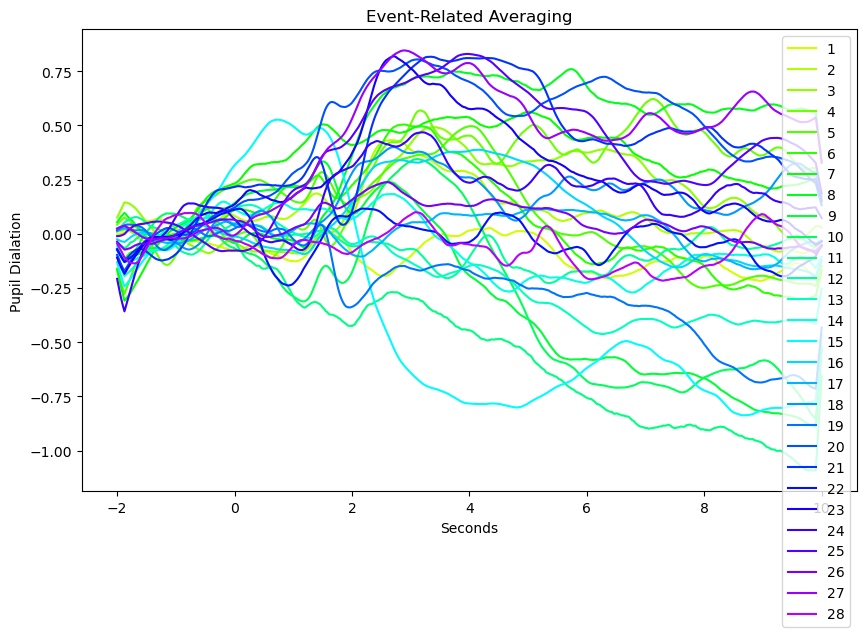

In [851]:
ep_test = PRF_first_tone(pupil_df, df_beh, df, range(1,29))

In [838]:
df_beh.keys()

Index(['frequencies', 'frequencies_oct', 'timing', 'timing_offset', 'run',
       'block', 'segment', 'center_freq_a', 'center_freq_b',
       'center_freq_a_oct', 'center_freq_b_oct', 'probability_a',
       'probability_b', 'stimulus', 'drex_surp', 'ideal_obs', 'block_count',
       'bpr', 'segment_all', 'stim_count', 'spr'],
      dtype='object')

In [842]:
def model_change(subs = range(1,2), deconv = False, t_res = False):
    
    for idx,subNr in enumerate(subs):
        pupil_df, df_beh, df = load_n_plot_subj(subNr, False)
        
        if deconv == True:
            # use PRF for deconvolution
            resp_fct = ep_test[:,subNr]
            
            for blk in range(0,144):
                # resp_fct_pad = np.pad(resp_fct, (0, (e_idxs[blk]-b_idxs[blk]) - len(resp_fct)), mode='constant')
            
                deconvolved_data, _ = deconvolve(df.loc[b_idxs[blk]:e_idxs[blk],'pupil'], resp_fct)

                deconvolved_data_pad =  np.pad(deconvolved_data, (0, (e_idxs[blk]-b_idxs[blk])+1 - len(deconvolved_data)), mode='constant')
                
                df.loc[b_idxs[blk]:e_idxs[blk],'deconv_data'] = deconvolved_data_pad

        if t_res == True:
            for blk in range(0,144):
                # find peaks in pupil data
                block_peaks = find_peaks(df.loc[b_idxs[blk]:e_idxs[blk],'pupil'])

                # find left and right boundary of full width at half maximum (FWHM)
                results_half = peak_widths(df.loc[b_idxs[blk]:e_idxs[blk],'pupil'], block_peaks[0], rel_height=0.5)         
                results_full = peak_widths(df.loc[b_idxs[blk]:e_idxs[blk],'pupil'], block_peaks[0], rel_height=1)

                # what to do with afterwards?

        # settings
        sampling_rate = round(1/np.mean(np.diff(df.time[0:9])))
        baseline = (-2,0)
        t_start = -5
        t_end = 20
        smoothingwindow = 10

        nbins = 6                         # number of bins
        binlabels = np.arange(0,nbins)    # create nbins
    
        event_id = {"RAND-dRAND": 6,       # define eventnames
                    "RAND-RAND" : 5,
                    "RAND-REG": 4,
                    "REG-dREG": 3,
                    "REG-RAND": 2,
                    "REG-REG": 1}
        
        ## get start and end of segment
        # create a shifted column to compare with the current segment
        df_beh['shifted_segment'] = df_beh['segment'].shift(1)
        
        # indicate where the model changes
        df_beh['start_seg'] = ((df_beh['segment'] != df_beh['shifted_segment']) & (df_beh['segment'] != 1)).astype(int)
        
        # drop the shifted column as it's not needed anymore
        df_beh.drop('shifted_segment', axis=1, inplace=True)
        
        model_change_idxs = df_beh[df_beh['start_seg'] == 1]['start_seg'].index.tolist()
        
        ## get amount of model change
        df_beh['mod_change'] = 0
        
        # Define a dictionary for conditions
        # 1: REG; 2: RAND; 3: dREG
        #             REG-REG    REG-RAND   REG-dREG   RAND-REG   RAND-RAND  RAND-dRAND
        conditions = {(1, 1): 1, (1, 2): 2, (1, 3): 3, (2, 1): 4, (2, 2): 5, (2, 3): 6}
        
        for i in range(len(model_change_idxs)):
            idx_cur = model_change_idxs[i]
            mod_cur = df_beh.loc[idx_cur, 'probability_a'] - df_beh.loc[idx_cur, 'probability_b']
            mod_min_one = df_beh.loc[idx_cur - 1, 'probability_a'] - df_beh.loc[idx_cur - 1, 'probability_b']
        
            # get prev model name
            mod_name_min = 1 if abs(mod_min_one) >= 0.4 else 2

            # get current model name
            if mod_name_min == 1:
                if abs(mod_cur) >= 0.4:
                    mod_name = 3 if (not same_sign(mod_cur, mod_min_one)) else 1
                else:
                    mod_name = 2
            else:
                if abs(mod_cur) >= 0.4:
                    mod_name = 1
                else:
                    mod_name = 3 if (not same_sign(mod_cur, mod_min_one)) else 2
            
            # get condition from dictionary
            condition = conditions.get((mod_name_min, mod_name))
            if condition:
                df_beh.loc[idx_cur, 'mod_change'] = condition
        
        df_beh['mod_change'] = df_beh['mod_change'].astype(float)

        # stimulus_to_col = df_beh.set_index('block')['mod_change'].to_dict()
        stimulus_to_col = df_beh.loc[df_beh['start_seg']>0].set_index('block')['mod_change'].to_dict()
        # # map function to go from one to another
        df['mod_change'] = df['block'].map(stimulus_to_col).fillna(0)
        
        ######
        # fetch pupildata
        pupildata = np.atleast_2d(df['pupil'].T.to_numpy())
        ch_names = ['pupildata']
        ch_types = ['pupil']
        event_info = mne.create_info(ch_names= ch_names, ch_types= ch_types, sfreq= sampling_rate)
        
        # create raw
        raw = mne.io.RawArray(pupildata, event_info)
              
        # Add an empty stimulus channel ## WHY??
        stim_data = np.zeros((1, len(raw.times)))
        info = mne.create_info(['mod_change'], raw.info['sfreq'], ['stim'])
        stim_raw = mne.io.RawArray(stim_data, info)
        raw.add_channels([stim_raw], force_update_info=True)
        
        # add event from our dataframe
        raw = add_event_from_df(raw, df, 'mod_change')
        events = mne.find_events(raw) # Find events
        
        # create epochs
        epochs = mne.Epochs(raw, events, event_id, tmin=t_start, tmax=t_end, preload=True, baseline=None) # performs subtractive baseline correction
        # return epochs
        
        # deconvolve
        # epochs.apply_function(lambda x: deconvolve(x, ep_test[:,subNr]), picks=['pupil'])
        
        # z-scoring
        epochs.apply_function(lambda x: zscore(x), picks=['pupil'])

        # baseline
        epochs.apply_baseline(baseline=baseline)
        
        ## plot REG segment first
        # predefine plot
        fig, ax = plt.subplots(1, 1, sharex=True, figsize=(10, 6))

        # Generate a color map from red to blue
        n_conditions = len(event_id.keys())
        colors = plt.cm.gist_heat(np.linspace(0.2, 0.8, 3))
        
        # check
        data = epochs['REG-REG'].times, epochs['REG-REG'].get_data().mean(0)[0, :]
        plt.plot(data[0],_temporal_smooth(data[1],smoothingwindow), label='REG-REG', color=colors[0])
        data = epochs['REG-dREG'].times, epochs['REG-dREG'].get_data().mean(0)[0, :]
        plt.plot(data[0],_temporal_smooth(data[1],smoothingwindow), label='REG-dREG', color=colors[-1])
        data = epochs['REG-RAND'].times, epochs['REG-RAND'].get_data().mean(0)[0, :]
        plt.plot(data[0],_temporal_smooth(data[1],smoothingwindow), label='REG-RAND', color=colors[1])
        
        # modify plot
        ax.set_title('Event-Related Averaging - Model Change (specific)')
        ax.set_xlabel('Seconds')
        ax.set_ylabel('Pupil Dialation')
        ax.legend()
        plt.show()

        ## plot RAND segment first
        # predefine plot
        fig, ax = plt.subplots(1, 1, sharex=True, figsize=(10, 6))

        # Generate a color map from red to blue
        n_conditions = len(event_id.keys())
        colors = plt.cm.gist_heat(np.linspace(0.2, 0.8, 3))
        
        # check
        data = epochs['RAND-REG'].times, epochs['RAND-REG'].get_data().mean(0)[0, :]
        plt.plot(data[0],_temporal_smooth(data[1],smoothingwindow), label='RAND-REG', color=colors[0])
        data = epochs['RAND-dRAND'].times, epochs['RAND-dRAND'].get_data().mean(0)[0, :]
        plt.plot(data[0],_temporal_smooth(data[1],smoothingwindow), label='RAND-dRAND', color=colors[-1])
        data = epochs['RAND-RAND'].times, epochs['RAND-RAND'].get_data().mean(0)[0, :]
        plt.plot(data[0],_temporal_smooth(data[1],smoothingwindow), label='RAND-RAND', color=colors[1])
        
        # modify plot
        ax.set_title('Event-Related Averaging - Model Change (specific)')
        ax.set_xlabel('Seconds')
        ax.set_ylabel('Pupil Dialation')
        ax.legend()
        plt.show()

        #### plot frequency domain
        minfreq = 1
        maxfreq = 8.0
        
        downsample_factor = 20  #i.e. from 0.025ms to 0.5ms timesteps
        
        # predefine plot
        fig, ax = plt.subplots(1, 1, sharex=True, figsize=(10, 6))
        
        # Generate a color map from red to blue
        n_conditions = len(event_id.keys())
        colors = plt.cm.gist_heat(np.linspace(0.2, 0.8, len(event_id.keys())))
        
        for cond, color in zip(event_id.keys(), colors):
        
            # number of sample points
            N = epochs[cond].get_data().shape[-1] # number of sample points
            
            # get y and x in freq domain
            yf = fft(epochs[cond].average().get_data()[0,:])
            xf = fftfreq(N ,   
                         np.diff(epochs[cond].times)[0])[:N //2]     # sample spacing
        
            # downsample
            yf = yf[::downsample_factor]
            xf = xf[::downsample_factor]
            
            # minfreq
            min_freqs = np.where((xf > minfreq) & (xf < maxfreq))
        
            # now plot
            plt.plot(xf[min_freqs], 2.0/N * np.abs(yf[min_freqs]), label=cond, color=color)
        
        # pimp plot
        ax.set_title('Frequency Domain Plot - Model Change')
        ax.set_xlabel('Frequency')
        ax.set_ylabel('Power')
        
        # Add a legend
        ax.legend()
        plt.show()

S04_beh  -  S04
Creating RawArray with float64 data, n_channels=1, n_times=119731
    Range : 0 ... 119730 =      0.000 ...  2993.250 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=119731
    Range : 0 ... 119730 =      0.000 ...  2993.250 secs
Ready.
8640 events found on stim channel FIR_onoff
Event IDs: [1]
Not setting metadata
8640 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 8640 events and 1361 original time points ...
96 bad epochs dropped
Creating RawArray with float64 data, n_channels=1, n_times=119731
    Range : 0 ... 119730 =      0.000 ...  2993.250 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=119731
    Range : 0 ... 119730 =      0.000 ...  2993.250 secs
Ready.
144 events found on stim channel mod_change
Event IDs: [1 2 3 4 5 6]
Not setting metadata
144 matching events found
No baseline correction applied
0 projection items activated
Using data from pre

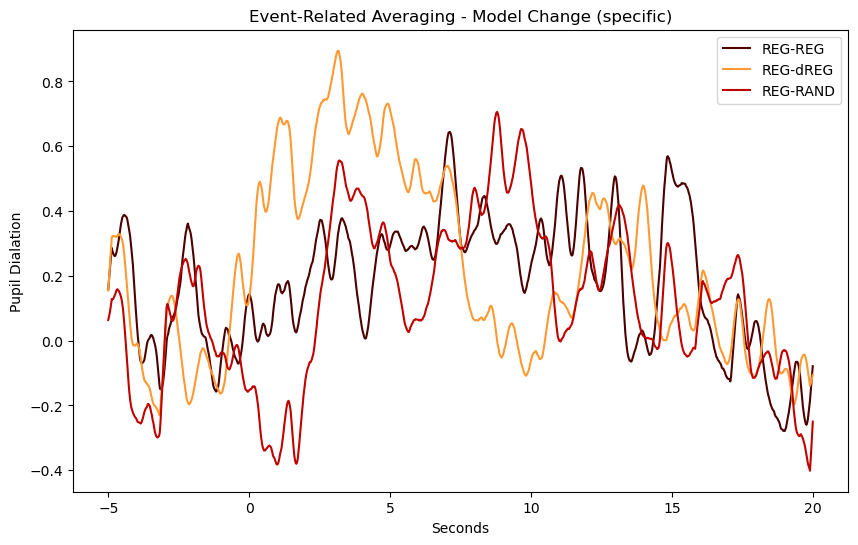

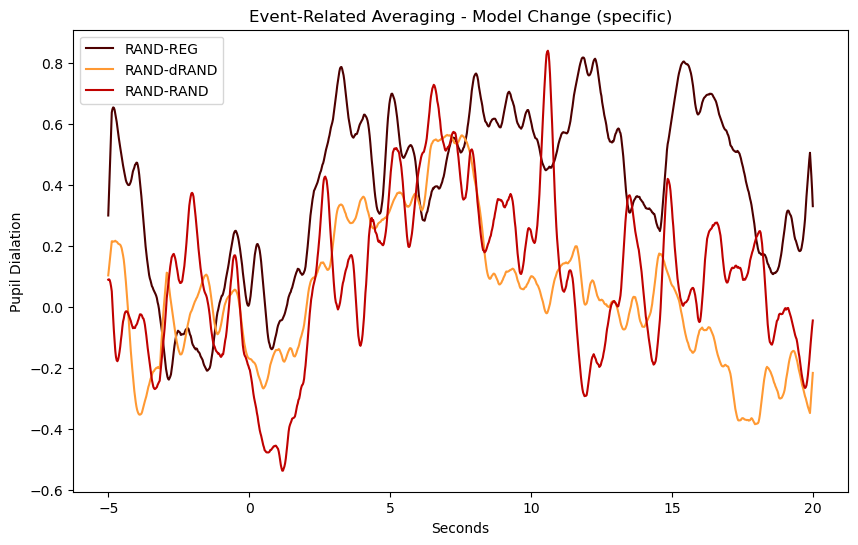

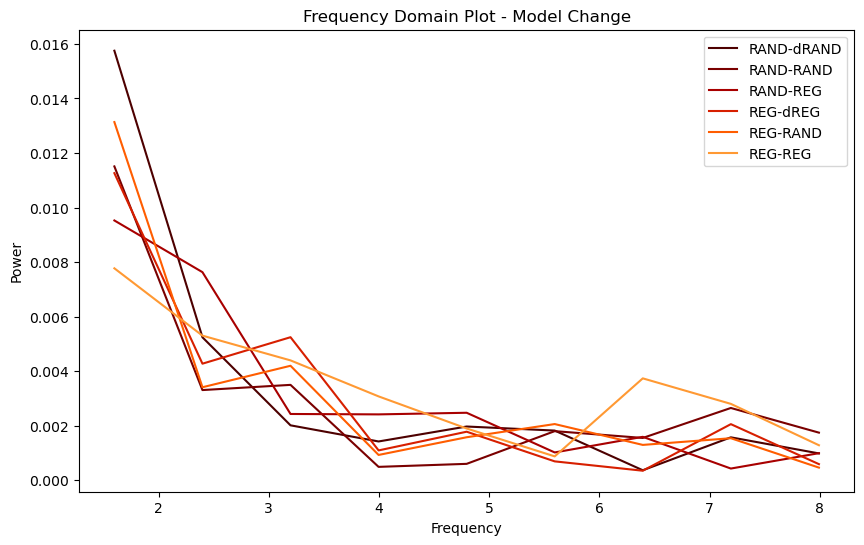

S05_beh  -  S05


/home/jorvhar/miniconda3/envs/pypil/lib/python3.11/site-packages/sklearn/mixture/_base.py:119: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  .fit(X)


Creating RawArray with float64 data, n_channels=1, n_times=119744
    Range : 0 ... 119743 =      0.000 ...  2993.575 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=119744
    Range : 0 ... 119743 =      0.000 ...  2993.575 secs
Ready.
8640 events found on stim channel FIR_onoff
Event IDs: [1]
Not setting metadata
8640 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 8640 events and 1361 original time points ...
96 bad epochs dropped
Creating RawArray with float64 data, n_channels=1, n_times=119744
    Range : 0 ... 119743 =      0.000 ...  2993.575 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=119744
    Range : 0 ... 119743 =      0.000 ...  2993.575 secs
Ready.
144 events found on stim channel mod_change
Event IDs: [1 2 3 4 5 6]
Not setting metadata
144 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1

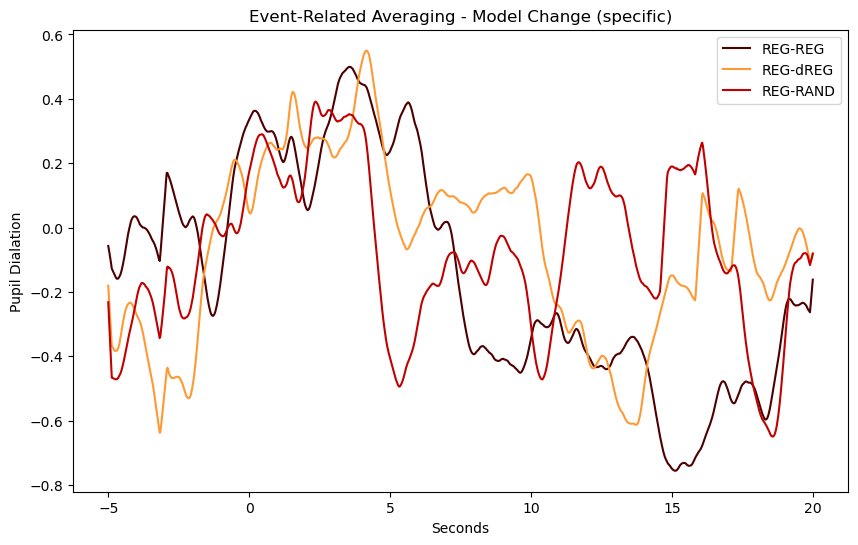

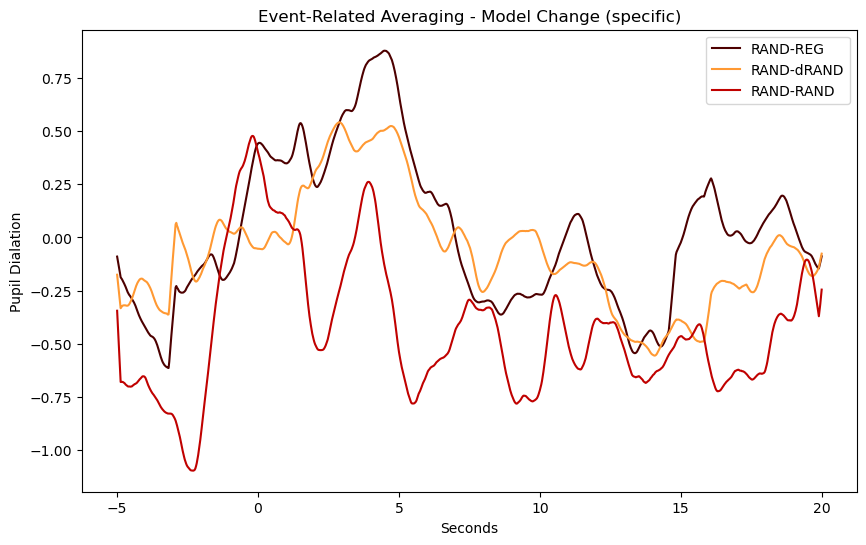

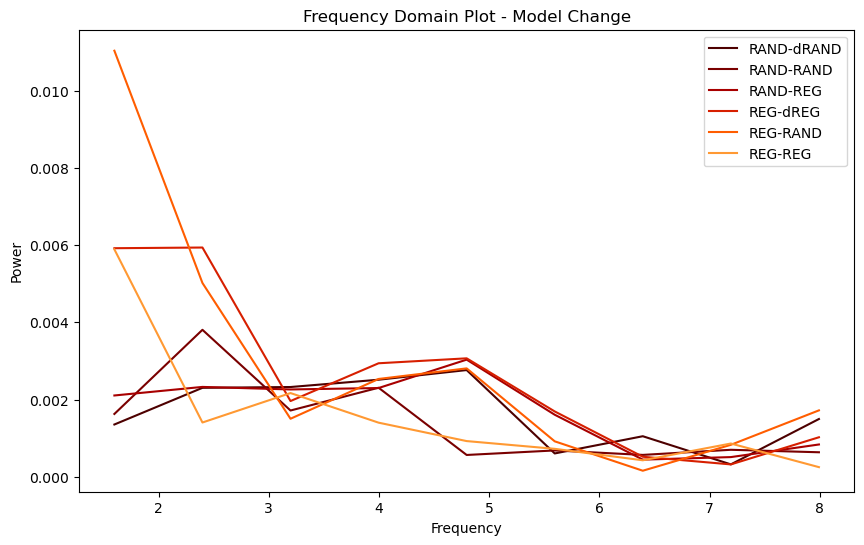

S06_beh  -  S06


/home/jorvhar/miniconda3/envs/pypil/lib/python3.11/site-packages/sklearn/mixture/_base.py:119: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  .fit(X)
/home/jorvhar/miniconda3/envs/pypil/lib/python3.11/site-packages/sklearn/mixture/_base.py:119: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  .fit(X)


Creating RawArray with float64 data, n_channels=1, n_times=119746
    Range : 0 ... 119745 =      0.000 ...  2993.625 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=119746
    Range : 0 ... 119745 =      0.000 ...  2993.625 secs
Ready.
8640 events found on stim channel FIR_onoff
Event IDs: [1]
Not setting metadata
8640 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 8640 events and 1361 original time points ...
96 bad epochs dropped
Creating RawArray with float64 data, n_channels=1, n_times=119746
    Range : 0 ... 119745 =      0.000 ...  2993.625 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=119746
    Range : 0 ... 119745 =      0.000 ...  2993.625 secs
Ready.
144 events found on stim channel mod_change
Event IDs: [1 2 3 4 5 6]
Not setting metadata
144 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1

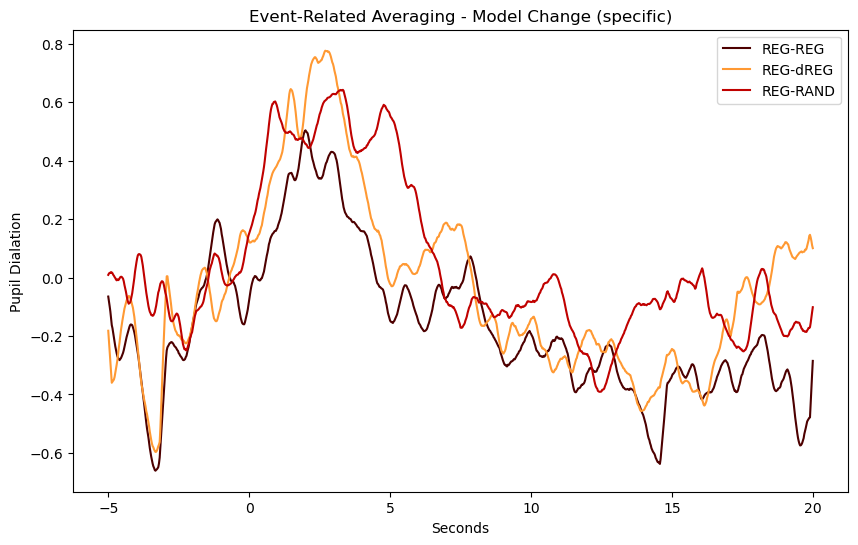

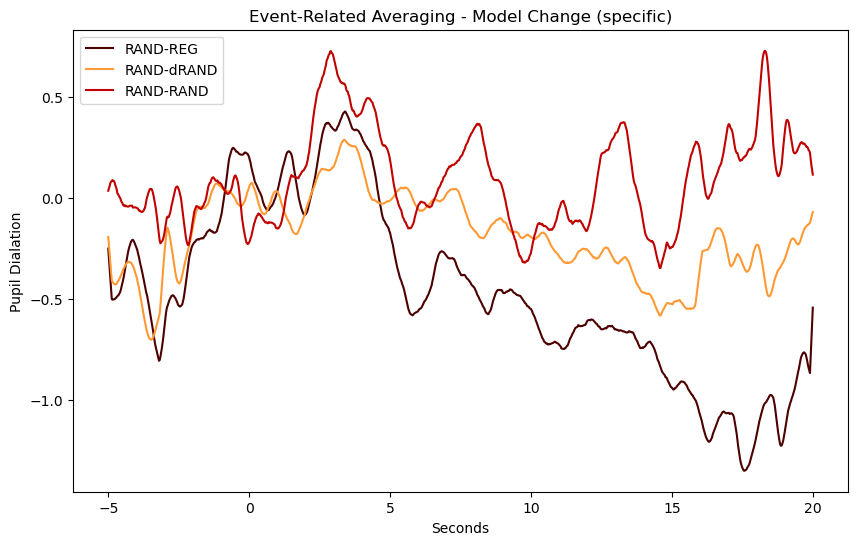

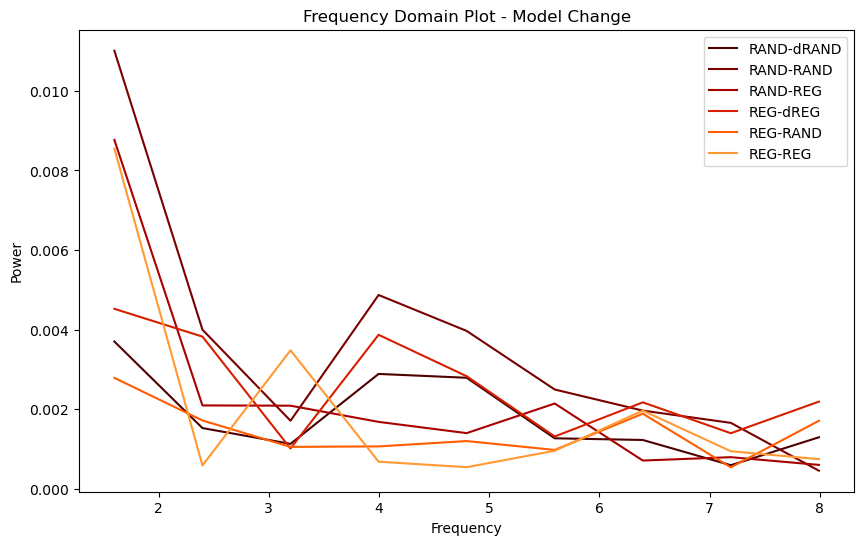

In [843]:
model_change(range(4,7), False, False)

In [835]:
2 * -2 > 0

False

In [820]:
ev_test = model_change(range(1,2), False, False)
ev_test

Number of events,142
Events,RAND-RAND: 15RAND-REG: 24RAND-dRAND: 32REG-RAND: 23REG-REG: 24REG-dREG: 24
Time range,-5.000 – 20.000 s
Baseline,-2.000 – 0.000 s


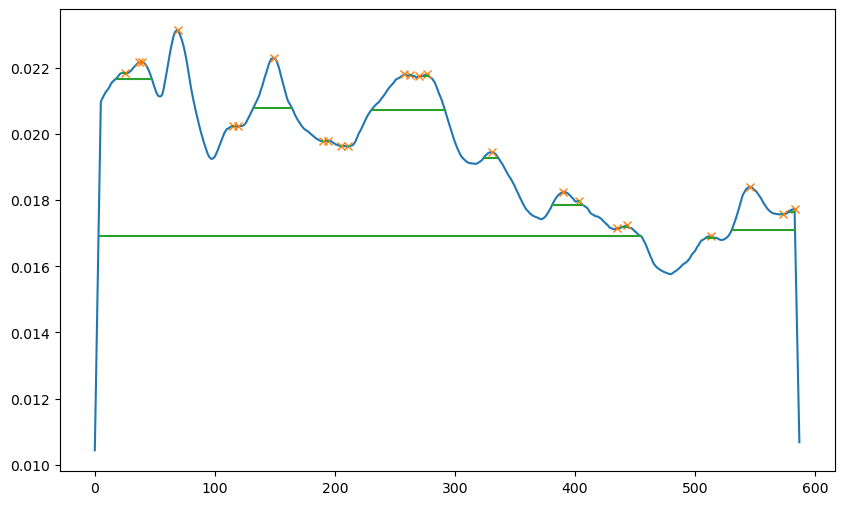

In [849]:
# plot FWHM
blk = 1
# ticks = 10

x = df.loc[b_idxs[blk]:e_idxs[blk],'pupil'].copy()
orig_ran = np.arange(x.index.min(),x.index.max(), ((x.index.max()-x.index.min())/ticks) , dtype=int)

x = x.reset_index()
x = x.drop('index', axis=1) 
x = x['pupil']
x = _temporal_smooth(x,10)
peaks, _ = find_peaks(x)

results_half = peak_widths(x, peaks, rel_height=0.5)
results_full = peak_widths(x, peaks, rel_height=1)

fig, ax = plt.subplots(1, 1, sharex=True, figsize=(10, 6))
plt.plot(x)
plt.plot(peaks, x[peaks], "x")
plt.hlines(*results_half[1:], color="C2")
# plt.hlines(*results_full[1:], color="C3")
# ax.set_xticks(np.arange(x.index.min(),x.index.max(), ((x.index.max()-x.index.min())/ticks),dtype=int ),orig_ran) # set new axis ticks
plt.show()

In [315]:
pupil_df, df_beh, df = load_n_plot_subj(1, False)

S01_beh  -  S01


/home/jorvhar/miniconda3/envs/pypil/lib/python3.11/site-packages/sklearn/mixture/_base.py:119: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  .fit(X)
/home/jorvhar/miniconda3/envs/pypil/lib/python3.11/site-packages/sklearn/mixture/_base.py:119: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  .fit(X)


144
Creating RawArray with float64 data, n_channels=1, n_times=119745
    Range : 0 ... 119744 =      0.000 ...  2993.600 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=119745
    Range : 0 ... 119744 =      0.000 ...  2993.600 secs
Ready.
5568 events found on stim channel FIR_onoff
Event IDs: [1]
Not setting metadata
5568 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 5568 events and 1361 original time points ...
100 bad epochs dropped


## Comparison between participants

In [1044]:
def compare_mod_change(subs = range(1,2), sub_excl = [], deconv = False):
    
    # define parameters for data array
    num_cond = 6
    len_epoch = 1001
    data_arr = np.zeros(shape=(len(subs),num_cond,len_epoch))

    for idx,subNr in enumerate(subs):

        # exclude data, if applicable
        if subNr in sub_excl:
            print('skipping subject', subNr)

            # create array of nans
            nan_arr = np.empty(len_epoch)
            nan_arr[:] = np.nan

            # setting data for subject to nan
            data_arr[idx,0,:] = nan_arr
            data_arr[idx,1,:] = nan_arr
            data_arr[idx,2,:] = nan_arr
            data_arr[idx,3,:] = nan_arr
            data_arr[idx,4,:] = nan_arr
            data_arr[idx,5,:] = nan_arr

            # skip subject
            continue

        # load data
        pupil_df, df_beh, df = load_n_plot_subj(subNr, False)

        # settings
        sampling_rate = round(1/np.mean(np.diff(df.time[0:9])))
        baseline = (-2,0)
        t_start = -2
        t_end = 15
        smoothingwindow = 10

        nbins = num_cond                  # number of bins
        binlabels = np.arange(0,nbins)    # create nbins
    
        event_id = {"RAND-dRAND": 6,       # define eventnames
                    "RAND-RAND" : 5,
                    "RAND-REG": 4,
                    "REG-dREG": 3,
                    "REG-RAND": 2,
                    "REG-REG": 1}
        
        ## get start and end of segment
        # create a shifted column to compare with the current segment
        df_beh['shifted_segment'] = df_beh['segment'].shift(1)
        
        # indicate where the model changes
        df_beh['start_seg'] = ((df_beh['segment'] != df_beh['shifted_segment']) & (df_beh['segment'] != 1)).astype(int)
        
        # drop the shifted column as it's not needed anymore
        df_beh.drop('shifted_segment', axis=1, inplace=True)
        
        model_change_idxs = df_beh[df_beh['start_seg'] == 1]['start_seg'].index.tolist()
        
        ## get amount of model change
        df_beh['mod_change'] = 0
        
        # Define a dictionary for conditions
        # 1: REG; 2: RAND; 3: dREG/dRAND
        #             REG-REG    REG-RAND   REG-dREG   RAND-REG   RAND-RAND  RAND-dRAND
        conditions = {(1, 1): 1, (1, 2): 2, (1, 3): 3, (2, 1): 4, (2, 2): 5, (2, 3): 6}
        
        for i in range(len(model_change_idxs)):
            idx_cur = model_change_idxs[i]
            mod_cur = df_beh.loc[idx_cur, 'probability_a'] - df_beh.loc[idx_cur, 'probability_b']
            mod_min_one = df_beh.loc[idx_cur - 1, 'probability_a'] - df_beh.loc[idx_cur - 1, 'probability_b']
        
            # get prev model name
            mod_name_min = 1 if abs(mod_min_one) >= 0.4 else 2

            # get current model name
            if mod_name_min == 1:
                if abs(mod_cur) >= 0.4:
                    mod_name = 3 if (not same_sign(mod_cur, mod_min_one)) else 1
                else:
                    mod_name = 2
            else:
                if abs(mod_cur) >= 0.4:
                    mod_name = 1
                else:
                    mod_name = 3 if (not same_sign(mod_cur, mod_min_one)) else 2
            
            # get condition from dictionary
            condition = conditions.get((mod_name_min, mod_name))
            if condition:
                df_beh.loc[idx_cur, 'mod_change'] = condition
        
        df_beh['mod_change'] = df_beh['mod_change'].astype(float)

        stimulus_to_col = df_beh.loc[df_beh['start_seg']>0].set_index('block')['mod_change'].to_dict()
        # # map function to go from one to another
        df['mod_change'] = df['block'].map(stimulus_to_col).fillna(0)
        
        ######
        # fetch pupildata
        pupildata = np.atleast_2d(df['pupil'].T.to_numpy())
        ch_names = ['pupildata']
        ch_types = ['pupil']
        event_info = mne.create_info(ch_names= ch_names, ch_types= ch_types, sfreq= sampling_rate)
        
        # create raw
        raw = mne.io.RawArray(pupildata, event_info)
              
        # Add an empty stimulus channel
        stim_data = np.zeros((1, len(raw.times)))
        info = mne.create_info(['mod_change'], raw.info['sfreq'], ['stim'])
        stim_raw = mne.io.RawArray(stim_data, info)
        raw.add_channels([stim_raw], force_update_info=True)
        
        # add event from our dataframe
        raw = add_event_from_df(raw, df, 'mod_change')
        events = mne.find_events(raw) # Find events
        
        # create epochs
        epochs = mne.Epochs(raw, events, event_id, tmin=t_start, tmax=t_end, preload=True, baseline=None) 
        
        # z-scoring
        epochs.apply_function(lambda x: zscore(x), picks=['pupil'])

        # baseline
        epochs.apply_baseline(baseline=baseline) # performs subtractive baseline correction

        # save data in array
        data_arr[idx,0,:]  = epochs['RAND-REG'].get_data().mean(0)[0, :]
        data_arr[idx,1,:]  = epochs['RAND-dRAND'].get_data().mean(0)[0, :]
        data_arr[idx,2,:]  = epochs['RAND-RAND'].get_data().mean(0)[0, :]
        data_arr[idx,3,:]  = epochs['REG-REG'].get_data().mean(0)[0, :]
        data_arr[idx,4,:]  = epochs['REG-dREG'].get_data().mean(0)[0, :]
        data_arr[idx,5,:]  = epochs['REG-RAND'].get_data().mean(0)[0, :]

    # averaging data over sujects
    rare_avg    = np.nanmean(data_arr[:,0,:], axis=0)
    radra_avg   = np.nanmean(data_arr[:,1,:], axis=0)
    rara_avg    = np.nanmean(data_arr[:,2,:], axis=0)
    rere_avg    = np.nanmean(data_arr[:,3,:], axis=0)
    redre_avg   = np.nanmean(data_arr[:,4,:], axis=0)
    rera_avg    = np.nanmean(data_arr[:,5,:], axis=0)

    # bootstrapping data
    rand_state = None
    
    rare_avg_low, rare_avg_up = bootstrap_confidence_interval(rare_avg, random_state=rand_state, stat_fun='mean')
    radra_avg_low, radra_avg_up = bootstrap_confidence_interval(radra_avg, random_state=rand_state, stat_fun='mean')
    rara_avg_low, rara_avg_up = bootstrap_confidence_interval(rara_avg, random_state=rand_state, stat_fun='mean')
    rere_avg_low, rere_avg_up = bootstrap_confidence_interval(rere_avg, random_state=rand_state, stat_fun='mean')
    redre_avg_low, redre_avg_up = bootstrap_confidence_interval(redre_avg, random_state=rand_state, stat_fun='mean')
    rera_avg_low, rera_avg_up = bootstrap_confidence_interval(rera_avg, random_state=rand_state, stat_fun='mean')

    ######
    # plotting REG as first segments
    ######
    # predefine plot
    fig, ax = plt.subplots(1, 1, sharex=True, figsize=(10, 6))
    
    # Generate a color map from red to blue
    n_conditions = len(event_id.keys())
    colors = plt.cm.gist_heat(np.linspace(0.2, 0.8, 3))
    
    # check
    data = epochs['REG-REG'].times, rere_avg
    ax.plot(data[0],data[1], label='REG-REG', color=colors[0])
    ax.fill_between(data[0], (data[1]- rere_avg_low), (data[1]+ rere_avg_up), color=colors[0], alpha=.15)
    data = epochs['REG-dREG'].times, redre_avg
    ax.plot(data[0],data[1], label='REG-dREG', color=colors[-1])
    ax.fill_between(data[0], (data[1]- redre_avg_low), (data[1]+ redre_avg_up), color=colors[-1], alpha=.15)
    data = epochs['REG-RAND'].times, rera_avg
    ax.plot(data[0],data[1], label='REG-RAND', color=colors[1])
    ax.fill_between(data[0], (data[1]- rera_avg_low), (data[1]+ rera_avg_up), color=colors[-1], alpha=.15)
    
    # modify plot
    ax.set_title('Event-Related Averaging over subjects- Model Change')
    ax.set_xlabel('Seconds')
    ax.set_ylabel('Pupil Dialation')
    ax.legend()
    plt.show()

    ######
    # plotting RAND as first segments
    ######
    # predefine plot
    fig, ax = plt.subplots(1, 1, sharex=True, figsize=(10, 6))
    
    # Generate a color map from red to blue
    n_conditions = len(event_id.keys())
    colors = plt.cm.gist_heat(np.linspace(0.2, 0.8, 3))
    
    # check
    data = epochs['RAND-REG'].times, rare_avg
    ax.plot(data[0],data[1], label='RAND-REG', color=colors[0])
    ax.fill_between(data[0], (data[1]- rare_avg_low), (data[1]+ rare_avg_up), color=colors[0], alpha=.15)
    data = epochs['RAND-dRAND'].times, radra_avg
    ax.plot(data[0],data[1], label='RAND-dRAND', color=colors[-1])
    ax.fill_between(data[0], (data[1]- radra_avg_low), (data[1]+ radra_avg_up), color=colors[-1], alpha=.15)
    data = epochs['RAND-RAND'].times, rara_avg
    ax.plot(data[0],data[1], label='RAND-RAND', color=colors[1])
    ax.fill_between(data[0], (data[1]- rara_avg_low), (data[1]+ rara_avg_up), color=colors[-1], alpha=.15)
    
    # modify plot
    ax.set_title('Event-Related Averaging over subjects- Model Change')
    ax.set_xlabel('Seconds')
    ax.set_ylabel('Pupil Dialation')
    ax.legend()
    plt.show()

    ######
    # plot frequency domain
    ######
    minfreq = 1
    maxfreq = 8.0
    
    downsample_factor = 20  #i.e. from 0.025ms to 0.5ms timesteps
    
    # predefine plot
    fig, ax = plt.subplots(1, 1, sharex=True, figsize=(10, 6))
    
    # Generate a color map from red to blue
    n_conditions = len(event_id.keys())
    colors = plt.cm.gist_heat(np.linspace(0.2, 0.8, len(event_id.keys())))
    
    for cond, color in zip(event_id.keys(), colors):
    
        # number of sample points
        N = epochs[cond].get_data().shape[-1] # number of sample points
        
        # get y and x in freq domain
        yf = fft(epochs[cond].average().get_data()[0,:])
        xf = fftfreq(N ,   
                     np.diff(epochs[cond].times)[0])[:N //2]     # sample spacing
    
        # downsample
        yf = yf[::downsample_factor]
        xf = xf[::downsample_factor]
        
        # minfreq
        min_freqs = np.where((xf > minfreq) & (xf < maxfreq))
    
        # now plot
        plt.plot(xf[min_freqs], 2.0/N * np.abs(yf[min_freqs]), label=cond, color=color)
    
    # pimp plot
    ax.set_title('Frequency Domain Plot - Model Change')
    ax.set_xlabel('Frequency')
    ax.set_ylabel('Power')
    
    # Add a legend
    ax.legend()
    plt.show()

    
    ## plot FFT data
    # settings
    minfreq = 1
    maxfreq = 8.0
    downsample_factor = 20  #i.e. from 0.025ms to 0.5ms timesteps
    
    # predefine plot
    fig, ax = plt.subplots(1, 1, sharex=True, figsize=(10, 6))
    
    # Generate a color map from red to blue
    colors = plt.cm.gist_heat(np.linspace(0.2, 0.8, num_cond))
    
    ## REG-REG
    # get y and x in freq domain
    yf = fft(rere_avg)
    xf = fftfreq(len_epoch , np.mean(np.diff(df.time[0:9])) )[:len_epoch //2]       # sample spacing
    yf = yf[::downsample_factor]                          # downsample
    xf = xf[::downsample_factor]                          # downsample
    min_freqs = np.where((xf > minfreq) & (xf < maxfreq)) # minfreq
    plt.plot(xf[min_freqs], 2.0/len_epoch * np.abs(yf[min_freqs]), label='REG-REG', color=colors[0]) # now plot
    
    ## REG-RAND
    # get y and x in freq domain
    yf = fft(rera_avg)
    xf = fftfreq(len_epoch , np.mean(np.diff(df.time[0:9])) )[:len_epoch //2]       # sample spacing
    yf = yf[::downsample_factor]                          # downsample
    xf = xf[::downsample_factor]                          # downsample
    min_freqs = np.where((xf > minfreq) & (xf < maxfreq)) # minfreq
    plt.plot(xf[min_freqs], 2.0/len_epoch * np.abs(yf[min_freqs]), label='REG-RAND', color=colors[1]) # now plot
    
    ## REG-dREG
    # get y and x in freq domain
    yf = fft(redre_avg)
    xf = fftfreq(len_epoch , np.mean(np.diff(df.time[0:9])) )[:len_epoch //2]       # sample spacing
    yf = yf[::downsample_factor]                          # downsample
    xf = xf[::downsample_factor]                          # downsample
    min_freqs = np.where((xf > minfreq) & (xf < maxfreq)) # minfreq
    plt.plot(xf[min_freqs], 2.0/len_epoch * np.abs(yf[min_freqs]), label='REG-dREG', color=colors[2]) # now plot
    
    ## RAND-REG
    # get y and x in freq domain
    yf = fft(rare_avg)
    xf = fftfreq(len_epoch , np.mean(np.diff(df.time[0:9])) )[:len_epoch //2]       # sample spacing
    yf = yf[::downsample_factor]                          # downsample
    xf = xf[::downsample_factor]                          # downsample
    min_freqs = np.where((xf > minfreq) & (xf < maxfreq)) # minfreq
    plt.plot(xf[min_freqs], 2.0/len_epoch * np.abs(yf[min_freqs]), label='RAND-REG', color=colors[3]) # now plot
    
    ## RAND-RAND
    # get y and x in freq domain
    yf = fft(rara_avg)
    xf = fftfreq(len_epoch , np.mean(np.diff(df.time[0:9])) )[:len_epoch //2]       # sample spacing
    yf = yf[::downsample_factor]                          # downsample
    xf = xf[::downsample_factor]                          # downsample
    min_freqs = np.where((xf > minfreq) & (xf < maxfreq)) # minfreq
    plt.plot(xf[min_freqs], 2.0/len_epoch * np.abs(yf[min_freqs]), label='RAND-RAND', color=colors[4]) # now plot
    
    ## RAND-dRAND
    # get y and x in freq domain
    yf = fft(radra_avg)
    xf = fftfreq(len_epoch , np.mean(np.diff(df.time[0:9])) )[:len_epoch //2]       # sample spacing
    yf = yf[::downsample_factor]                          # downsample
    xf = xf[::downsample_factor]                          # downsample
    min_freqs = np.where((xf > minfreq) & (xf < maxfreq)) # minfreq
    plt.plot(xf[min_freqs], 2.0/len_epoch * np.abs(yf[min_freqs]), label='RAND-dRAND', color=colors[5]) # now plot
    
    # pimp plot
    ax.set_title('Frequency Domain Plot - Model Change')
    ax.set_xlabel('Frequency')
    ax.set_ylabel('Power')
    
    # Add a legend
    ax.legend()
    plt.show()

S01_beh  -  S01


/home/jorvhar/miniconda3/envs/pypil/lib/python3.11/site-packages/sklearn/mixture/_base.py:119: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  .fit(X)
/home/jorvhar/miniconda3/envs/pypil/lib/python3.11/site-packages/sklearn/mixture/_base.py:119: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  .fit(X)


Creating RawArray with float64 data, n_channels=1, n_times=119745
    Range : 0 ... 119744 =      0.000 ...  2993.600 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=119745
    Range : 0 ... 119744 =      0.000 ...  2993.600 secs
Ready.
5568 events found on stim channel FIR_onoff
Event IDs: [1]
Not setting metadata
5568 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 5568 events and 1361 original time points ...
100 bad epochs dropped
Creating RawArray with float64 data, n_channels=1, n_times=119745
    Range : 0 ... 119744 =      0.000 ...  2993.600 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=119745
    Range : 0 ... 119744 =      0.000 ...  2993.600 secs
Ready.
144 events found on stim channel mod_change
Event IDs: [1 2 3 4 5 6]
Not setting metadata
144 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 

/home/jorvhar/miniconda3/envs/pypil/lib/python3.11/site-packages/sklearn/mixture/_base.py:119: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  .fit(X)


Creating RawArray with float64 data, n_channels=1, n_times=119744
    Range : 0 ... 119743 =      0.000 ...  2993.575 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=119744
    Range : 0 ... 119743 =      0.000 ...  2993.575 secs
Ready.
8640 events found on stim channel FIR_onoff
Event IDs: [1]
Not setting metadata
8640 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 8640 events and 1361 original time points ...
96 bad epochs dropped
Creating RawArray with float64 data, n_channels=1, n_times=119744
    Range : 0 ... 119743 =      0.000 ...  2993.575 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=119744
    Range : 0 ... 119743 =      0.000 ...  2993.575 secs
Ready.
144 events found on stim channel mod_change
Event IDs: [1 2 3 4 5 6]
Not setting metadata
144 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1

/home/jorvhar/miniconda3/envs/pypil/lib/python3.11/site-packages/sklearn/mixture/_base.py:119: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  .fit(X)
/home/jorvhar/miniconda3/envs/pypil/lib/python3.11/site-packages/sklearn/mixture/_base.py:119: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  .fit(X)


Creating RawArray with float64 data, n_channels=1, n_times=119746
    Range : 0 ... 119745 =      0.000 ...  2993.625 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=119746
    Range : 0 ... 119745 =      0.000 ...  2993.625 secs
Ready.
8640 events found on stim channel FIR_onoff
Event IDs: [1]
Not setting metadata
8640 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 8640 events and 1361 original time points ...
96 bad epochs dropped
Creating RawArray with float64 data, n_channels=1, n_times=119746
    Range : 0 ... 119745 =      0.000 ...  2993.625 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=119746
    Range : 0 ... 119745 =      0.000 ...  2993.625 secs
Ready.
144 events found on stim channel mod_change
Event IDs: [1 2 3 4 5 6]
Not setting metadata
144 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1

/home/jorvhar/miniconda3/envs/pypil/lib/python3.11/site-packages/sklearn/mixture/_base.py:119: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  .fit(X)
/home/jorvhar/miniconda3/envs/pypil/lib/python3.11/site-packages/sklearn/mixture/_base.py:119: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  .fit(X)


Creating RawArray with float64 data, n_channels=1, n_times=119740
    Range : 0 ... 119739 =      0.000 ...  2993.475 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=119740
    Range : 0 ... 119739 =      0.000 ...  2993.475 secs
Ready.
8640 events found on stim channel FIR_onoff
Event IDs: [1]
Not setting metadata
8640 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 8640 events and 1361 original time points ...
96 bad epochs dropped
Creating RawArray with float64 data, n_channels=1, n_times=119740
    Range : 0 ... 119739 =      0.000 ...  2993.475 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=119740
    Range : 0 ... 119739 =      0.000 ...  2993.475 secs
Ready.
144 events found on stim channel mod_change
Event IDs: [1 2 3 4 5 6]
Not setting metadata
144 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1

/home/jorvhar/miniconda3/envs/pypil/lib/python3.11/site-packages/sklearn/mixture/_base.py:119: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  .fit(X)
/home/jorvhar/miniconda3/envs/pypil/lib/python3.11/site-packages/sklearn/mixture/_base.py:119: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  .fit(X)


Creating RawArray with float64 data, n_channels=1, n_times=119782
    Range : 0 ... 119781 =      0.000 ...  2994.525 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=119782
    Range : 0 ... 119781 =      0.000 ...  2994.525 secs
Ready.
5390 events found on stim channel FIR_onoff
Event IDs: [1]
Not setting metadata
5390 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 5390 events and 1361 original time points ...
4 bad epochs dropped
Creating RawArray with float64 data, n_channels=1, n_times=119782
    Range : 0 ... 119781 =      0.000 ...  2994.525 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=119782
    Range : 0 ... 119781 =      0.000 ...  2994.525 secs
Ready.
144 events found on stim channel mod_change
Event IDs: [1 2 3 4 5 6]
Not setting metadata
144 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 14

/home/jorvhar/miniconda3/envs/pypil/lib/python3.11/site-packages/sklearn/mixture/_base.py:119: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  .fit(X)


Creating RawArray with float64 data, n_channels=1, n_times=119772
    Range : 0 ... 119771 =      0.000 ...  2994.275 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=119772
    Range : 0 ... 119771 =      0.000 ...  2994.275 secs
Ready.
8640 events found on stim channel FIR_onoff
Event IDs: [1]
Not setting metadata
8640 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 8640 events and 1361 original time points ...
96 bad epochs dropped
Creating RawArray with float64 data, n_channels=1, n_times=119772
    Range : 0 ... 119771 =      0.000 ...  2994.275 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=119772
    Range : 0 ... 119771 =      0.000 ...  2994.275 secs
Ready.
144 events found on stim channel mod_change
Event IDs: [1 2 3 4 5 6]
Not setting metadata
144 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1

/home/jorvhar/miniconda3/envs/pypil/lib/python3.11/site-packages/sklearn/mixture/_base.py:119: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  .fit(X)
/home/jorvhar/miniconda3/envs/pypil/lib/python3.11/site-packages/sklearn/mixture/_base.py:119: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  .fit(X)


Creating RawArray with float64 data, n_channels=1, n_times=119775
    Range : 0 ... 119774 =      0.000 ...  2994.350 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=119775
    Range : 0 ... 119774 =      0.000 ...  2994.350 secs
Ready.
8640 events found on stim channel FIR_onoff
Event IDs: [1]
Not setting metadata
8640 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 8640 events and 1361 original time points ...
96 bad epochs dropped
Creating RawArray with float64 data, n_channels=1, n_times=119775
    Range : 0 ... 119774 =      0.000 ...  2994.350 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=119775
    Range : 0 ... 119774 =      0.000 ...  2994.350 secs
Ready.
144 events found on stim channel mod_change
Event IDs: [1 2 3 4 5 6]
Not setting metadata
144 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1

/home/jorvhar/miniconda3/envs/pypil/lib/python3.11/site-packages/sklearn/mixture/_base.py:119: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  .fit(X)


Creating RawArray with float64 data, n_channels=1, n_times=120365
    Range : 0 ... 120364 =      0.000 ...  3009.100 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=120365
    Range : 0 ... 120364 =      0.000 ...  3009.100 secs
Ready.
4977 events found on stim channel FIR_onoff
Event IDs: [1]
Not setting metadata
4977 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 4977 events and 1361 original time points ...
85 bad epochs dropped
Creating RawArray with float64 data, n_channels=1, n_times=120365
    Range : 0 ... 120364 =      0.000 ...  3009.100 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=120365
    Range : 0 ... 120364 =      0.000 ...  3009.100 secs
Ready.
144 events found on stim channel mod_change
Event IDs: [1 2 3 4 5 6]
Not setting metadata
144 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1

/home/jorvhar/miniconda3/envs/pypil/lib/python3.11/site-packages/sklearn/mixture/_base.py:119: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  .fit(X)


Creating RawArray with float64 data, n_channels=1, n_times=119769
    Range : 0 ... 119768 =      0.000 ...  2994.200 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=119769
    Range : 0 ... 119768 =      0.000 ...  2994.200 secs
Ready.
8640 events found on stim channel FIR_onoff
Event IDs: [1]
Not setting metadata
8640 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 8640 events and 1361 original time points ...
96 bad epochs dropped
Creating RawArray with float64 data, n_channels=1, n_times=119769
    Range : 0 ... 119768 =      0.000 ...  2994.200 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=119769
    Range : 0 ... 119768 =      0.000 ...  2994.200 secs
Ready.
144 events found on stim channel mod_change
Event IDs: [1 2 3 4 5 6]
Not setting metadata
144 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1

/home/jorvhar/miniconda3/envs/pypil/lib/python3.11/site-packages/sklearn/mixture/_base.py:119: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  .fit(X)
/home/jorvhar/miniconda3/envs/pypil/lib/python3.11/site-packages/sklearn/mixture/_base.py:119: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  .fit(X)


Creating RawArray with float64 data, n_channels=1, n_times=119775
    Range : 0 ... 119774 =      0.000 ...  2994.350 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=119775
    Range : 0 ... 119774 =      0.000 ...  2994.350 secs
Ready.
8640 events found on stim channel FIR_onoff
Event IDs: [1]
Not setting metadata
8640 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 8640 events and 1361 original time points ...
96 bad epochs dropped
Creating RawArray with float64 data, n_channels=1, n_times=119775
    Range : 0 ... 119774 =      0.000 ...  2994.350 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=119775
    Range : 0 ... 119774 =      0.000 ...  2994.350 secs
Ready.
144 events found on stim channel mod_change
Event IDs: [1 2 3 4 5 6]
Not setting metadata
144 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1

/home/jorvhar/miniconda3/envs/pypil/lib/python3.11/site-packages/sklearn/mixture/_base.py:119: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  .fit(X)
/home/jorvhar/miniconda3/envs/pypil/lib/python3.11/site-packages/sklearn/mixture/_base.py:119: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  .fit(X)
/home/jorvhar/miniconda3/envs/pypil/lib/python3.11/site-packages/sklearn/mixture/_base.py:119: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  .fit(X)
/home/jorvhar/miniconda3/envs/pypil/lib/python3.11/site-packages/sklearn/mixture/_base.py:119: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  .fit(X)
/home/jorvhar/miniconda3/envs/pypil/lib/python3.11/site-packages/sklearn/mix

Creating RawArray with float64 data, n_channels=1, n_times=119775
    Range : 0 ... 119774 =      0.000 ...  2994.350 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=119775
    Range : 0 ... 119774 =      0.000 ...  2994.350 secs
Ready.
8640 events found on stim channel FIR_onoff
Event IDs: [1]
Not setting metadata
8640 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 8640 events and 1361 original time points ...
96 bad epochs dropped
Creating RawArray with float64 data, n_channels=1, n_times=119775
    Range : 0 ... 119774 =      0.000 ...  2994.350 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=119775
    Range : 0 ... 119774 =      0.000 ...  2994.350 secs
Ready.
144 events found on stim channel mod_change
Event IDs: [1 2 3 4 5 6]
Not setting metadata
144 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1

/home/jorvhar/miniconda3/envs/pypil/lib/python3.11/site-packages/sklearn/mixture/_base.py:119: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  .fit(X)


Creating RawArray with float64 data, n_channels=1, n_times=119774
    Range : 0 ... 119773 =      0.000 ...  2994.325 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=119774
    Range : 0 ... 119773 =      0.000 ...  2994.325 secs
Ready.
8640 events found on stim channel FIR_onoff
Event IDs: [1]
Not setting metadata
8640 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 8640 events and 1361 original time points ...
96 bad epochs dropped
Creating RawArray with float64 data, n_channels=1, n_times=119774
    Range : 0 ... 119773 =      0.000 ...  2994.325 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=119774
    Range : 0 ... 119773 =      0.000 ...  2994.325 secs
Ready.
144 events found on stim channel mod_change
Event IDs: [1 2 3 4 5 6]
Not setting metadata
144 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1

/home/jorvhar/miniconda3/envs/pypil/lib/python3.11/site-packages/sklearn/mixture/_base.py:119: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  .fit(X)
/home/jorvhar/miniconda3/envs/pypil/lib/python3.11/site-packages/sklearn/mixture/_base.py:119: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  .fit(X)
/home/jorvhar/miniconda3/envs/pypil/lib/python3.11/site-packages/sklearn/mixture/_base.py:119: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  .fit(X)
/home/jorvhar/miniconda3/envs/pypil/lib/python3.11/site-packages/sklearn/mixture/_base.py:119: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  .fit(X)
/home/jorvhar/miniconda3/envs/pypil/lib/python3.11/site-packages/sklearn/mix

Creating RawArray with float64 data, n_channels=1, n_times=119785
    Range : 0 ... 119784 =      0.000 ...  2994.600 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=119785
    Range : 0 ... 119784 =      0.000 ...  2994.600 secs
Ready.
8640 events found on stim channel FIR_onoff
Event IDs: [1]
Not setting metadata
8640 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 8640 events and 1361 original time points ...
96 bad epochs dropped
Creating RawArray with float64 data, n_channels=1, n_times=119785
    Range : 0 ... 119784 =      0.000 ...  2994.600 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=119785
    Range : 0 ... 119784 =      0.000 ...  2994.600 secs
Ready.
144 events found on stim channel mod_change
Event IDs: [1 2 3 4 5 6]
Not setting metadata
144 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1

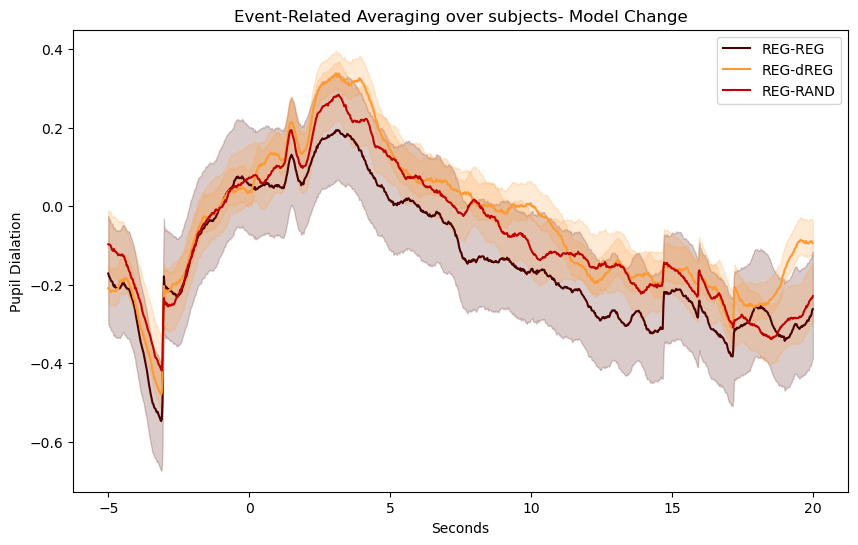

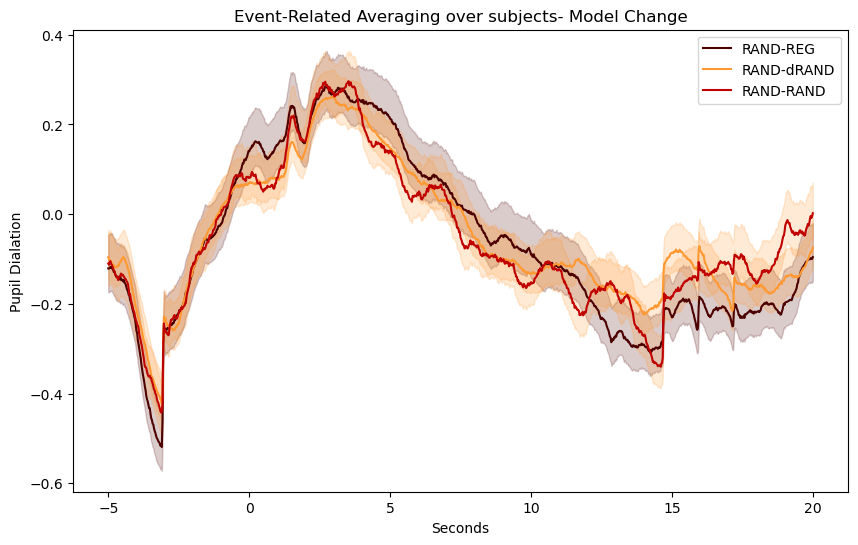

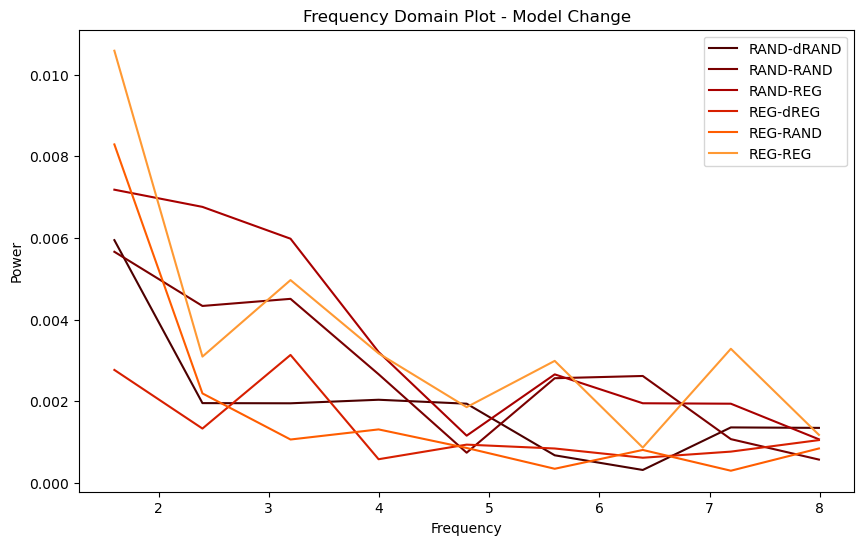

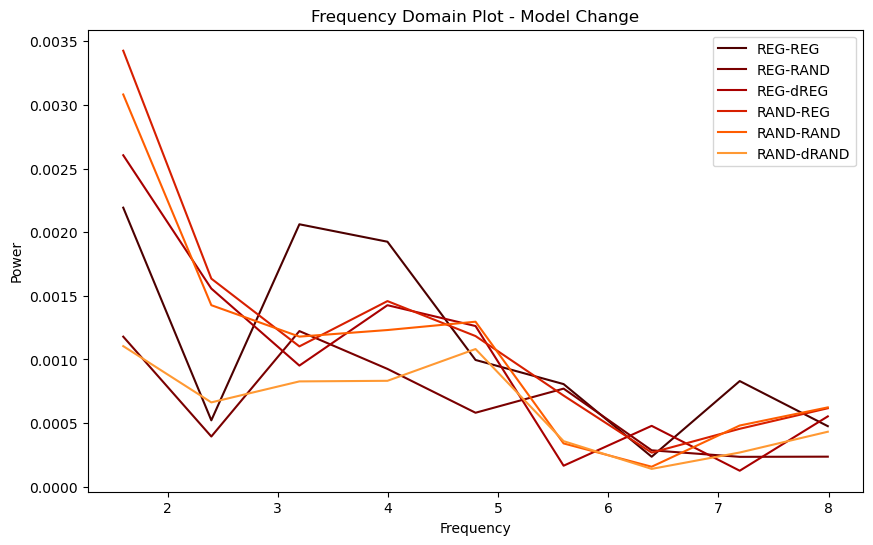

In [998]:
# rare_avg, radra_avg, rara_avg, rere_avg, redre_avg, rera_avg, times = compare_mod_change(subs = range(4,6) , deconv = False)
compare_mod_change(subs = range(1,29), sub_excl=[3, 12, 14, 23] , deconv = False)
# data_arr = compare_mod_change(subs = range(1,5), sub_excl=[3, 12, 14, 23] , deconv = False) 

In [ ]:
compare_mod_change(subs = range(1,29), sub_excl=[3, 12, 14, 23] , deconv = False)

In [991]:
def stat_fun(x, axis = 0):
    """Return sum of squares."""
    return np.nanmean(x,axis=0) #np.sum(x**2, axis=0)

# bootstrapping
rare_avg_low, rare_avg_up = bootstrap_confidence_interval(data_arr[:,0,:], random_state=None, stat_fun=stat_fun)
rare_avg_low
# radra_avg_low, radra_avg_up = bootstrap_confidence_interval(data_arr[:,1,:], random_state=None, stat_fun='mean')
# rara_avg_low, rara_avg_up = bootstrap_confidence_interval(data_arr[:,2,:], random_state=None, stat_fun='mean')
# rere_avg_low, rere_avg_up = bootstrap_confidence_interval(data_arr[:,3,:], random_state=None, stat_fun='mean')
# redre_avg_low, redre_avg_up = bootstrap_confidence_interval(data_arr[:,4,:], random_state=None, stat_fun='mean')
# rera_avg_low, rera_avg_up = bootstrap_confidence_interval(data_arr[:,5,:], random_state=None, stat_fun='mean')

/tmp/ipykernel_1078946/3263855550.py:3: RuntimeWarning: Mean of empty slice
  return np.nanmean(x,axis=0) #np.sum(x**2, axis=0)


array([nan, nan, nan, ..., nan, nan, nan])

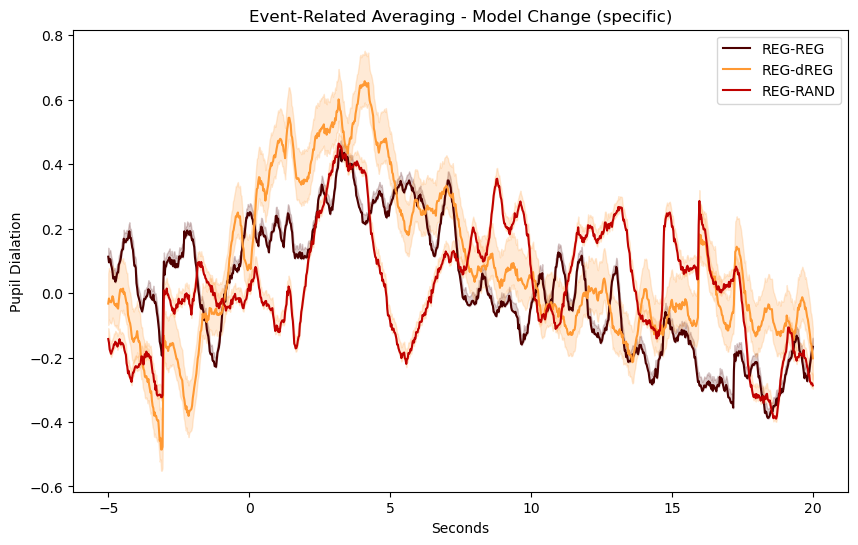

In [899]:
event_id = {"RAND-dRAND": 6,       # define eventnames
            "RAND-RAND" : 5,
            "RAND-REG": 4,
            "REG-dREG": 3,
            "REG-RAND": 2,
            "REG-REG": 1}

## plot REG segment first
# predefine plot
fig, ax = plt.subplots(1, 1, sharex=True, figsize=(10, 6))

# Generate a color map from red to blue
n_conditions = len(event_id.keys())
colors = plt.cm.gist_heat(np.linspace(0.2, 0.8, 3))

# check
data = times, rere_avg
ax.plot(data[0],data[1], label='REG-REG', color=colors[0])
ax.fill_between(data[0], (data[1]- rere_avg_low), (data[1]+ rere_avg_up), color=colors[0], alpha=.2)
data = times, redre_avg
ax.plot(data[0],data[1], label='REG-dREG', color=colors[-1])
ax.fill_between(data[0], (data[1]- redre_avg_low), (data[1]+ redre_avg_up), color=colors[-1], alpha=.2)
data = times, rera_avg
ax.plot(data[0],data[1], label='REG-RAND', color=colors[1])
ax.fill_between(data[0], (data[1]- rera_avg_low), (data[1]+ rera_avg_up), color=colors[-1], alpha=.2)

# modify plot
ax.set_title('Event-Related Averaging - Model Change (specific)')
ax.set_xlabel('Seconds')
ax.set_ylabel('Pupil Dialation')
ax.legend()
plt.show()

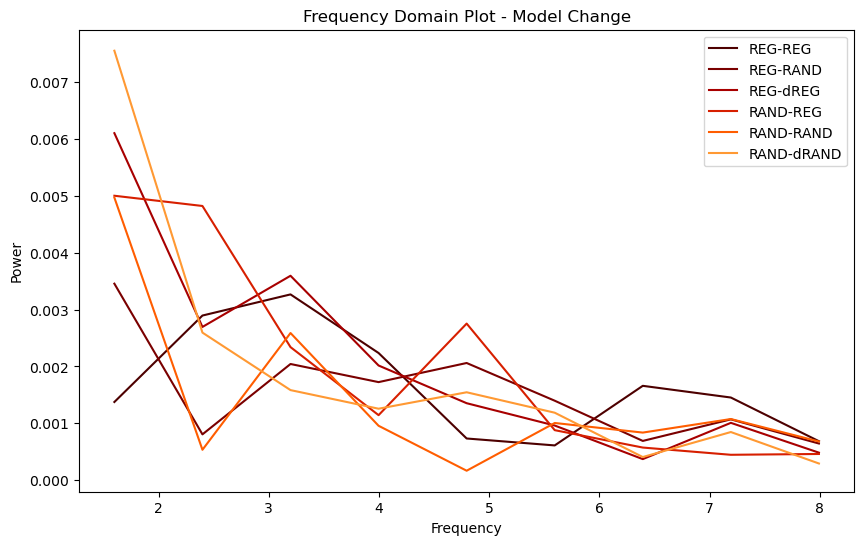

In [996]:
len_epoch = 1001
num_cond = 6

## plot FFT data
# settings
minfreq = 1
maxfreq = 8.0
downsample_factor = 20  #i.e. from 0.025ms to 0.5ms timesteps

# predefine plot
fig, ax = plt.subplots(1, 1, sharex=True, figsize=(10, 6))

# Generate a color map from red to blue
colors = plt.cm.gist_heat(np.linspace(0.2, 0.8, num_cond))

## REG-REG
# get y and x in freq domain
yf = fft(rere_avg)
xf = fftfreq(len_epoch , np.mean(np.diff(df.time[0:9])) )[:len_epoch //2]       # sample spacing
yf = yf[::downsample_factor]                          # downsample
xf = xf[::downsample_factor]                          # downsample
min_freqs = np.where((xf > minfreq) & (xf < maxfreq)) # minfreq
plt.plot(xf[min_freqs], 2.0/len_epoch * np.abs(yf[min_freqs]), label='REG-REG', color=colors[0]) # now plot

## REG-RAND
# get y and x in freq domain
yf = fft(rera_avg)
xf = fftfreq(len_epoch , np.mean(np.diff(df.time[0:9])) )[:len_epoch //2]       # sample spacing
yf = yf[::downsample_factor]                          # downsample
xf = xf[::downsample_factor]                          # downsample
min_freqs = np.where((xf > minfreq) & (xf < maxfreq)) # minfreq
plt.plot(xf[min_freqs], 2.0/len_epoch * np.abs(yf[min_freqs]), label='REG-RAND', color=colors[1]) # now plot

## REG-dREG
# get y and x in freq domain
yf = fft(redre_avg)
xf = fftfreq(len_epoch , np.mean(np.diff(df.time[0:9])) )[:len_epoch //2]       # sample spacing
yf = yf[::downsample_factor]                          # downsample
xf = xf[::downsample_factor]                          # downsample
min_freqs = np.where((xf > minfreq) & (xf < maxfreq)) # minfreq
plt.plot(xf[min_freqs], 2.0/len_epoch * np.abs(yf[min_freqs]), label='REG-dREG', color=colors[2]) # now plot

## RAND-REG
# get y and x in freq domain
yf = fft(rare_avg)
xf = fftfreq(len_epoch , np.mean(np.diff(df.time[0:9])) )[:len_epoch //2]       # sample spacing
yf = yf[::downsample_factor]                          # downsample
xf = xf[::downsample_factor]                          # downsample
min_freqs = np.where((xf > minfreq) & (xf < maxfreq)) # minfreq
plt.plot(xf[min_freqs], 2.0/len_epoch * np.abs(yf[min_freqs]), label='RAND-REG', color=colors[3]) # now plot

## RAND-RAND
# get y and x in freq domain
yf = fft(rara_avg)
xf = fftfreq(len_epoch , np.mean(np.diff(df.time[0:9])) )[:len_epoch //2]       # sample spacing
yf = yf[::downsample_factor]                          # downsample
xf = xf[::downsample_factor]                          # downsample
min_freqs = np.where((xf > minfreq) & (xf < maxfreq)) # minfreq
plt.plot(xf[min_freqs], 2.0/len_epoch * np.abs(yf[min_freqs]), label='RAND-RAND', color=colors[4]) # now plot

## RAND-dRAND
# get y and x in freq domain
yf = fft(radra_avg)
xf = fftfreq(len_epoch , np.mean(np.diff(df.time[0:9])) )[:len_epoch //2]       # sample spacing
yf = yf[::downsample_factor]                          # downsample
xf = xf[::downsample_factor]                          # downsample
min_freqs = np.where((xf > minfreq) & (xf < maxfreq)) # minfreq
plt.plot(xf[min_freqs], 2.0/len_epoch * np.abs(yf[min_freqs]), label='RAND-dRAND', color=colors[5]) # now plot

# pimp plot
ax.set_title('Frequency Domain Plot - Model Change')
ax.set_xlabel('Frequency')
ax.set_ylabel('Power')

# Add a legend
ax.legend()
plt.show()

In [951]:
def stat_fun(x):
    """Return sum of squares."""
    return np.nanmean(x,axis=0)#np.sum(x**2, axis=0)

def FWHM(X,Y):
    half_max = max(Y) / 2.
    #find when function crosses line half_max (when sign of diff flips)
    #take the 'derivative' of signum(half_max - Y[])
    d = np.sign(half_max - np.array(Y[0:-1])) - np.sign(half_max - np.array(Y[1:]))
    #plot(X[0:len(d)],d) #if you are interested
    #find the left and right most indexes
    left_idx = np.where(d > 0)[0]
    right_idx = np.where(d < 0)[-1]
    return X[right_idx] - X[left_idx] #return the difference (full width)